# Simulating Complex Physics with Graph Networks: step by step

## Overview

By Peng Chen, Shiyu Li, and Haochen Shi as part of the Stanford CS224W course project. This tutorial provides a step-by-step guide for how to build a Graph Network to simulate complex physics.

**Before we get started:**
- This Colab includes a concise PyG implementation of the paper ***Learning to Simulate Complex Physics with Graph Networks*. We adapted our code from the open-source tensorflow implementation by DeepMind.
    - Link to the pdf of this paper: https://arxiv.org/abs/2002.09405
    - Link to Deepmind's implementation: https://github.com/deepmind/deepmind-research/tree/master/learning_to_simulate
    - Link to the video site by DeepMind: https://sites.google.com/view/learning-to-simulate
- Make sure to **sequentially run all the cells in each section**, so that the intermediate variables / packages will carry over to the next cell.
- Feel free to make a copy to your own drive to play around with it! Have fun with this tutorial!

## Device

We recommend using a GPU for this Colab. Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

## Setup

The installation of PyG on Colab can be a little bit tricky. Before we get started, let's check which version of PyTorch you are running.

In [1]:
# Dataset Source #1:
# https://drive.google.com/file/d/1ZmiKpsQVLFxPOIff-LfFkZwe5ZYG1FEb/view?usp=drive_link

# Dataset Source #2:
# https://drive.google.com/drive/mobile/folders/11uuYl0peqPg2DQno64YPYMODPu8fjDXU?usp=sharing

In [2]:
#!pip install torch

In [3]:
import os
import torch
print(f"PyTorch has version {torch.__version__} with cuda {torch.version.cuda}")

PyTorch has version 1.12.1+cu102 with cuda 10.2



Download the necessary packages for PyG. Make sure that your version of torch matches the output from the cell above. In case of any issues, more information can be found on [PyG's installation page](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html)

In [4]:
!pip3 install torch==1.12.1+cu102 torchvision==0.13.1+cu102 torchaudio==0.12.1 torchtext --extra-index-url https://download.pytorch.org/whl/cu102
!pip install https://data.pyg.org/whl/torch-1.12.0%2Bcu102/torch_cluster-1.6.0%2Bpt112cu102-cp37-cp37m-linux_x86_64.whl
!pip install https://data.pyg.org/whl/torch-1.12.0%2Bcu102/torch_scatter-2.1.0%2Bpt112cu102-cp37-cp37m-linux_x86_64.whl
!pip install https://data.pyg.org/whl/torch-1.12.0%2Bcu102/torch_sparse-0.6.16%2Bpt112cu102-cp37-cp37m-linux_x86_64.whl
!pip install torch-geometric
!pip install matplotlib
!pip install networkx

# Dataset Preparation
cd /home/admin1/Desktop/gnndataset/datasets/WaterDrop/

# metadata.json
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1o6cKxgbnfUUFPTX1JngBzB928w2bUIwk' -O metadata.json

# test_offset.json
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vr4JiVliKCQNWVV4kziyusxNVUvQuAYL' -O test_offset.json

# test_particle_type.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Z_r9ivdKqKZzVJG80gb2uY6JDVRd0wAt' -O test_particle_type.dat

# test_position.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1wCeBz1pZ5hxmlqWw4eylajg6pzFgQjIJ' -O test_position.dat

# train_offset.json
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=160wnp9PEc1HuzsBi7kO0ryMu3tnon2tI' -O train_offset.json

# train_particle_type.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1LVtGLld7assF4sPk0mF2Bz2F7FBaxU0O' -O train_particle_type.dat

# train_position.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1YCXcir_fmJZLvXkbPjchsrr8VuuWugH0' -O train_position.dat

# valid_offset.json
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1tiDP5uHMJQDTNxyRNSb6sEZCWAADPu8a' -O valid_offset.json

# valid_particle_type.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fXIw9RWM0xzfK2sGn1H0DaAOxzm59ZEd' -O valid_particle_type.dat

# valid_position.dat
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1U9QuV3Ra0E1tDD1HgXYCYyn4SeLKXQGs' -O valid_position.dat


SyntaxError: invalid syntax (2781797817.py, line 10)

## Dataset

The dataset WaterDropSmall includes 100 videos of dropping water to the ground rendered in a particle-based physics simulator. It is a cropped version of the WaterDrop dataset by Deepmind. We will download this dataset from Google Cloud stoarge to the folder `temp/datasets` in the file system. You can inspect the downloaded files on the **Files** menu on the left of this Colab.

The `metadata.json` file in the dataset includes the following information:
1. The sequence length of each video data point
2. The dimensionality, 2d or 3d
3. The box bounds, which specify the bounding box for the scene
4. The default connectivity radius, which defines the size of each particle's neighborhood
5. The statistics for normalization, such as the mean and standard deviation of the velocity and acceleration of particles


Each data point in the dataset includes the following information:
1. The type of the particles, such as water
2. The particle positions at each frame in the video

In [5]:
DATASET_NAME = "WaterDrop"
OUTPUT_DIR = os.path.join("/home/admin1/Desktop/gnndataset/datasets/WaterDrop")

print("##################")
print("## DATASET_NAME ##")
print("##################")
print(DATASET_NAME)
print("")

print("################")
print("## OUTPUT_DIR ##")
print("################")
print(OUTPUT_DIR)
print("")

# BASE_URL = f"https://storage.googleapis.com/cs224w_course_project_dataset/{DATASET_NAME}"

# !mkdir -p "$OUTPUT_DIR"

# META_DATA_PATH = f"{OUTPUT_DIR}/metadata.json"
# CLOUD_PATH = f"{BASE_URL}/metadata.json"
# !wget -O "$META_DATA_PATH" "$CLOUD_PATH"
# for split in ["test", "train", "valid"]:
#   for suffix in ["offset.json", "particle_type.dat", "position.dat"]:
#       DATA_PATH = f"{OUTPUT_DIR}/{split}_{suffix}"
#       CLOUD_PATH = f"{BASE_URL}/{split}_{suffix}"
#       !wget -O "$DATA_PATH" "$CLOUD_PATH"

##################
## DATASET_NAME ##
##################
WaterDrop

################
## OUTPUT_DIR ##
################
/home/admin1/Desktop/gnndataset/datasets/WaterDrop



## Data Preprocessing

• Since cannot apply raw data in dataset to train GNN model directly, must go through following steps to convert raw data into graphs with descriptive node features and edge features:
1. Apply noise to trajectory to have more diverse training examples
1. Construct graph based on distance between particles
1. Extract node-level features: particle velocities and their distance to boundary
1. Extract edge-level features: displacement and distance between particles

• If you are not interested in data pipeline, your can skip to end of this section. 
• There is a detailed explanation and visualization of one data point.

In [6]:
!export LD_LIBRARY_PATH=/home/admin1/anaconda3/envs/GNN/lib:$LD_LIBRARY_PATH
    

In [7]:
import json
import numpy as np
import torch_geometric as pyg

def generate_noise(position_seq, noise_std):
    """Generate noise for a trajectory"""
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]
    time_steps = velocity_seq.size(1)
    velocity_noise = torch.randn_like(velocity_seq) * (noise_std / time_steps ** 0.5)
    velocity_noise = velocity_noise.cumsum(dim=1)
    position_noise = velocity_noise.cumsum(dim=1)
    position_noise = torch.cat((torch.zeros_like(position_noise)[:, 0:1], position_noise), dim=1)
    return position_noise


def preprocess(particle_type, position_seq, target_position, metadata, noise_std):
    """Preprocess a trajectory and construct the graph"""
    # apply noise to the trajectory
    position_noise = generate_noise(position_seq, noise_std)
    position_seq = position_seq + position_noise

    # calculate the velocities of particles
    recent_position = position_seq[:, -1]
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]

    # construct the graph based on the distances between particles
    n_particle = recent_position.size(0)
    edge_index = pyg.nn.radius_graph(recent_position, metadata["default_connectivity_radius"], loop=True, max_num_neighbors=n_particle)

    # node-level features: velocity, distance to the boundary
    normal_velocity_seq = (velocity_seq - torch.tensor(metadata["vel_mean"])) / torch.sqrt(torch.tensor(metadata["vel_std"]) ** 2 + noise_std ** 2)
    boundary = torch.tensor(metadata["bounds"])
    distance_to_lower_boundary = recent_position - boundary[:, 0]
    distance_to_upper_boundary = boundary[:, 1] - recent_position
    distance_to_boundary = torch.cat((distance_to_lower_boundary, distance_to_upper_boundary), dim=-1)
    distance_to_boundary = torch.clip(distance_to_boundary / metadata["default_connectivity_radius"], -1.0, 1.0)

    # edge-level features: displacement, distance
    dim = recent_position.size(-1)
    edge_displacement = (torch.gather(recent_position, dim=0, index=edge_index[0].unsqueeze(-1).expand(-1, dim)) -
                   torch.gather(recent_position, dim=0, index=edge_index[1].unsqueeze(-1).expand(-1, dim)))
    edge_displacement /= metadata["default_connectivity_radius"]
    edge_distance = torch.norm(edge_displacement, dim=-1, keepdim=True)

    # ground truth for training
    if target_position is not None:
        last_velocity = velocity_seq[:, -1]
        next_velocity = target_position + position_noise[:, -1] - recent_position
        acceleration = next_velocity - last_velocity
        acceleration = (acceleration - torch.tensor(metadata["acc_mean"])) / torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise_std ** 2)
    else:
        acceleration = None

    # return the graph with features
    graph = pyg.data.Data(
        x=particle_type,
        edge_index=edge_index,
        edge_attr=torch.cat((edge_displacement, edge_distance), dim=-1),
        y=acceleration,
        pos=torch.cat((velocity_seq.reshape(velocity_seq.size(0), -1), distance_to_boundary), dim=-1)
    )
    return graph

### One Step Dataset

• Each datapoint in this dataset contains trajectories sliced to short time windows. 

• will use this dataset in training phase because history of particles' states are necessary for model to make predictions. 

• But in meantime, since long-horizon prediction is inaccurate and time-consuming, sliced trajectories to short time windows to improve perfomance of model.

In [8]:
class OneStepDataset(pyg.data.Dataset):
    def __init__(self, data_path, split, window_length=7, noise_std=0.0, return_pos=False):
        super().__init__()

        print("###############")
        print("## data_path ##")
        print("###############")
        print(data_path)
        print("")

        
        # load dataset from the disk
        with open(os.path.join(data_path, "metadata.json")) as f:
            self.metadata = json.load(f)
        with open(os.path.join(data_path, f"{split}_offset.json")) as f:
            self.offset = json.load(f)
        self.offset = {int(k): v for k, v in self.offset.items()}
        self.window_length = window_length
        self.noise_std = noise_std
        self.return_pos = return_pos

        self.particle_type = np.memmap(os.path.join(data_path, f"{split}_particle_type.dat"), dtype=np.int64, mode="r")
        self.position = np.memmap(os.path.join(data_path, f"{split}_position.dat"), dtype=np.float32, mode="r")

        for traj in self.offset.values():
            self.dim = traj["position"]["shape"][2]
            break

        # cut particle trajectories according to time slices
        self.windows = []
        for traj in self.offset.values():
            size = traj["position"]["shape"][1]
            length = traj["position"]["shape"][0] - window_length + 1
            for i in range(length):
                desc = {
                    "size": size,
                    "type": traj["particle_type"]["offset"],
                    "pos": traj["position"]["offset"] + i * size * self.dim,
                }
                self.windows.append(desc)

    def len(self):
        return len(self.windows)

    def get(self, idx):
        # load corresponding data for this time slice
        window = self.windows[idx]
        size = window["size"]
        particle_type = self.particle_type[window["type"]: window["type"] + size].copy()
        particle_type = torch.from_numpy(particle_type)
        position_seq = self.position[window["pos"]: window["pos"] + self.window_length * size * self.dim].copy()
        position_seq.resize(self.window_length, size, self.dim)
        position_seq = position_seq.transpose(1, 0, 2)
        target_position = position_seq[:, -1]
        position_seq = position_seq[:, :-1]
        target_position = torch.from_numpy(target_position)
        position_seq = torch.from_numpy(position_seq)

        # construct the graph
        with torch.no_grad():
            graph = preprocess(particle_type, position_seq, target_position, self.metadata, self.noise_std)
        if self.return_pos:
          return graph, position_seq[:, -1]
        return graph

### Rollout Dataset

• Each datapoint in this dataset contains trajectories of particles over 1000 time frames. 

• This dataset used in evaluation phase to measure model's ability to make long-horizon predictions.

In [9]:
class RolloutDataset(pyg.data.Dataset):
    def __init__(self, data_path, split, window_length=7):
        super().__init__()

        # load data from the disk
        with open(os.path.join(data_path, "metadata.json")) as f:
            self.metadata = json.load(f)
        with open(os.path.join(data_path, f"{split}_offset.json")) as f:
            self.offset = json.load(f)
        self.offset = {int(k): v for k, v in self.offset.items()}
        self.window_length = window_length

        self.particle_type = np.memmap(os.path.join(data_path, f"{split}_particle_type.dat"), dtype=np.int64, mode="r")
        self.position = np.memmap(os.path.join(data_path, f"{split}_position.dat"), dtype=np.float32, mode="r")

        for traj in self.offset.values():
            self.dim = traj["position"]["shape"][2]
            break

    def len(self):
        return len(self.offset)

    def get(self, idx):
        traj = self.offset[idx]
        size = traj["position"]["shape"][1]
        time_step = traj["position"]["shape"][0]
        particle_type = self.particle_type[traj["particle_type"]["offset"]: traj["particle_type"]["offset"] + size].copy()
        particle_type = torch.from_numpy(particle_type)
        position = self.position[traj["position"]["offset"]: traj["position"]["offset"] + time_step * size * self.dim].copy()
        position.resize(traj["position"]["shape"])
        position = torch.from_numpy(position)
        data = {"particle_type": particle_type, "position": position}
        return data

### Visualize a graph in the dataset

Each data point in the dataset is a `pyg.data.Data` object which describes a graph. We explain the contents of the first data point, and visualize the graph.

###############
## data_path ##
###############
/home/admin1/Desktop/gnndataset/datasets/WaterDrop

The first item in the valid set is a graph: Data(x=[482], edge_index=[2, 3070], edge_attr=[3070, 3], y=[482, 2], pos=[482, 14])
This graph has 482 nodes and 3070 edges.
Each node is a particle and each edge is the interaction between two particles.
Each node has 1 categorial feature (Data.x), which represents the type of the node.
Each node has a 14-dim feature vector (Data.pos), which represents the positions and velocities of the particle (node) in several frames.
Each edge has a 3-dim feature vector (Data.edge_attr), which represents the relative distance and displacement between particles.
The model is expected to predict a 2-dim vector for each node (Data.y), which represents the acceleration of the particle.


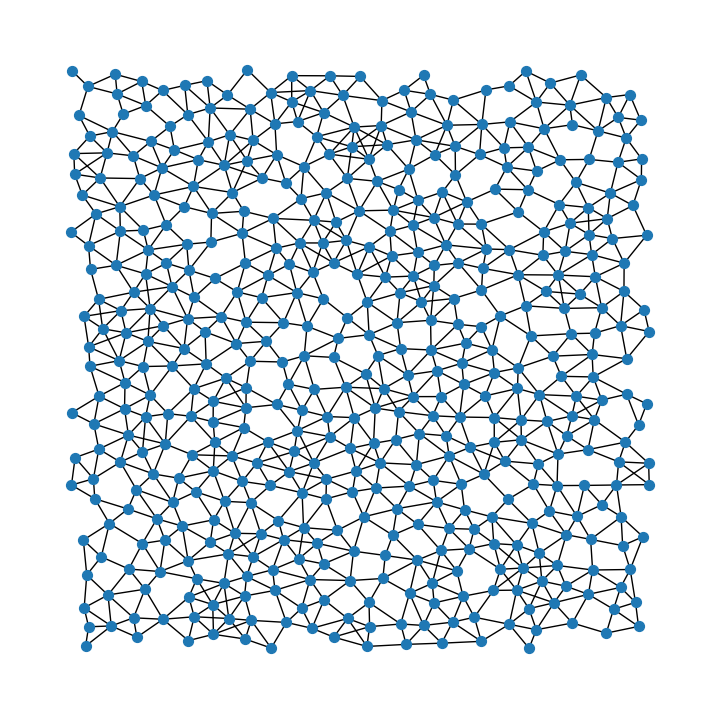

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

dataset_sample = OneStepDataset(OUTPUT_DIR, "valid", return_pos=True)
graph, position = dataset_sample[0]

print(f"The first item in the valid set is a graph: {graph}")
print(f"This graph has {graph.num_nodes} nodes and {graph.num_edges} edges.")
print(f"Each node is a particle and each edge is the interaction between two particles.")
print(f"Each node has {graph.num_node_features} categorial feature (Data.x), which represents the type of the node.")
print(f"Each node has a {graph.pos.size(1)}-dim feature vector (Data.pos), which represents the positions and velocities of the particle (node) in several frames.")
print(f"Each edge has a {graph.num_edge_features}-dim feature vector (Data.edge_attr), which represents the relative distance and displacement between particles.")
print(f"The model is expected to predict a {graph.y.size(1)}-dim vector for each node (Data.y), which represents the acceleration of the particle.")

# remove directions of edges, because it is a symmetric directed graph.
nx_graph = pyg.utils.to_networkx(graph).to_undirected()
# remove self loops, because every node has a self loop.
nx_graph.remove_edges_from(nx.selfloop_edges(nx_graph))
plt.figure(figsize=(7, 7))
nx.draw(nx_graph, pos={i: tuple(v) for i, v in enumerate(position)}, node_size=50)
plt.show()

## GNN Model

We will walk through the implementation of the GNN model in this section!

### Helper class

We first define a class for Multi-Layer Perceptron (MLP). This class generates an MLP given the width and the depth of it. Because MLPs are used in several places of the GNN, this helper class will make the code cleaner.

In [11]:
import math
import torch_scatter

class MLP(torch.nn.Module):
    """Multi-Layer perceptron"""
    def __init__(self, input_size, hidden_size, output_size, layers, layernorm=True):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(layers):
            self.layers.append(torch.nn.Linear(
                input_size if i == 0 else hidden_size,
                output_size if i == layers - 1 else hidden_size,
            ))
            if i != layers - 1:
                self.layers.append(torch.nn.ReLU())
        if layernorm:
            self.layers.append(torch.nn.LayerNorm(output_size))
        self.reset_parameters()

    def reset_parameters(self):
        for layer in self.layers:
            if isinstance(layer, torch.nn.Linear):
                layer.weight.data.normal_(0, 1 / math.sqrt(layer.in_features))
                layer.bias.data.fill_(0)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### GNN layers

In the following code block, we implement one type of GNN layer named `InteractionNetwork` (IN), which is proposed by the paper *Interaction Networks for Learning about Objects,
Relations and Physics*.

For a graph $G$, let the feature of node $i$ be $v_i$, and the feature of edge $(i, j)$ be $e_{i, j}$. There are three stages for IN to generate new features of nodes and edges.

1. **Message generation.** If there is an edge pointing from node $i$ to node $j$, node $i$ sends a message to node $j$. The message carries the information of the edge and its two nodes, so it is generated by the following equation $\mathrm{Msg}_{i,j} = \mathrm{MLP}(v_i, v_j, e_{i,j})$.

1. **Message aggregation.** In this stage, each node of the graph aggregates all the messages that it received to a fixed-sized representation. In the IN, aggregation means summing all the messages up, i.e., $\mathrm{Agg}_i=\sum_{(j,i)\in G}\mathrm{Msg}_{i,j}$.

1. **Update.** Finally, we update features of nodes and edges with the results of previous stages. For each edge, its new feature is simply the sum of its old feature and the correspond message, i.e., $e'_{i,j}=e_{i,j}+\mathrm{Msg}_{i,j}$. For each node, the new feature is determined by its old feature and the aggregated message, i.e., $v'_i=v_i+\mathrm{MLP}(v_i, \mathrm{Agg}_i)$.

In PyG, GNN layers are implemented as subclass of `MessagePassing`. We need to override three critical functions to implement our `InteractionNetwork` GNN layer. Each function corresponds to one stage of the GNN layer.

1. `message()` -> message generation

  This function controls how a message is generated on each edge of the graph. It takes three arguments: (1) `x_i`, features of the source nodes; (2) `x_j`, features of the target nodes; and (3) `edge_feature`, features of the edges themselves. In the IN, we simply concatenate all these features and generate the messages with an MLP.

1. `aggregate()` -> message aggregation

  This function aggregates messages for nodes. It depends on two arguments: (1) `inputs`, messages; and (2) `index`, the graph structure. We handle over the task of message aggregation to the function `torch_scatter.scatter` and specifies in the argument `reduce` that we want to sum messages up. Because we want to retain messages themselves to update edge features, we return both messages and aggregated messages.

1. `forward()` -> update

  This function puts everything together. `x` is the node features, `edge_index` is the graph structure and `edge_feature` is edge features. The function`MessagePassing.propagate` invokes functions `message` and `aggregate` for us. Then, we update node features and edge features and return them.

In [12]:
class InteractionNetwork(pyg.nn.MessagePassing):
    """Interaction Network as proposed in this paper:
    https://proceedings.neurips.cc/paper/2016/hash/3147da8ab4a0437c15ef51a5cc7f2dc4-Abstract.html"""
    def __init__(self, hidden_size, layers):
        super().__init__()
        self.lin_edge = MLP(hidden_size * 3, hidden_size, hidden_size, layers)
        self.lin_node = MLP(hidden_size * 2, hidden_size, hidden_size, layers)

    def forward(self, x, edge_index, edge_feature):
        edge_out, aggr = self.propagate(edge_index, x=(x, x), edge_feature=edge_feature)
        node_out = self.lin_node(torch.cat((x, aggr), dim=-1))
        edge_out = edge_feature + edge_out
        node_out = x + node_out
        return node_out, edge_out

    def message(self, x_i, x_j, edge_feature):
        x = torch.cat((x_i, x_j, edge_feature), dim=-1)
        x = self.lin_edge(x)
        return x

    def aggregate(self, inputs, index, dim_size=None):
        out = torch_scatter.scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce="sum")
        return (inputs, out)

### The GNN

Now its time to stack GNN layers to a GNN. Besides GNN layers, there are pre-processing and post-processing blocks in the GNN. Before GNN layers, input features are transformed by MLP so that the expressiveness of GNN is improved without increasing GNN layers. After GNN layers, final outputs (accelerations of particles in our case) are extracted from features generated by GNN layers to meet the requirement of the task.

In [13]:
class LearnedSimulator(torch.nn.Module):
    """Graph Network-based Simulators(GNS)"""
    def __init__(
        self,
        hidden_size=128,
        n_mp_layers=10, # number of GNN layers
        num_particle_types=9,
        particle_type_dim=16, # embedding dimension of particle types
        dim=2, # dimension of the world, typical 2D or 3D
        window_size=5, # the model looks into W frames before the frame to be predicted
    ):
        super().__init__()
        self.window_size = window_size
        self.embed_type = torch.nn.Embedding(num_particle_types, particle_type_dim)
        self.node_in = MLP(particle_type_dim + dim * (window_size + 2), hidden_size, hidden_size, 3)
        self.edge_in = MLP(dim + 1, hidden_size, hidden_size, 3)
        self.node_out = MLP(hidden_size, hidden_size, dim, 3, layernorm=False)
        self.n_mp_layers = n_mp_layers
        self.layers = torch.nn.ModuleList([InteractionNetwork(
            hidden_size, 3
        ) for _ in range(n_mp_layers)])

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embed_type.weight)

    def forward(self, data):
        # pre-processing
        # node feature: combine categorial feature data.x and contiguous feature data.pos.
        node_feature = torch.cat((self.embed_type(data.x), data.pos), dim=-1)
        node_feature = self.node_in(node_feature)
        edge_feature = self.edge_in(data.edge_attr)
        # stack of GNN layers
        for i in range(self.n_mp_layers):
            node_feature, edge_feature = self.layers[i](node_feature, data.edge_index, edge_feature=edge_feature)
        # post-processing
        out = self.node_out(node_feature)
        return out

## Training

Before we start training the model, let's configure the hyperparameters! Since the accessible computaion power is limited in Colab, we will only run 1 epoch of training, which takes about 1.5 hour. Consequently, we won't be able to produce as accurate results as shown in the original paper in this Colab. Alternatively, we provide a checkpoint of training the model on the entire WaterDrop dataset for 5 epochs, which takes about 14 hours with a GeForce RTX 3080 Ti.

In [14]:
data_path = OUTPUT_DIR
model_path = os.path.join("temp", "models", DATASET_NAME)
rollout_path = os.path.join("temp", "rollouts", DATASET_NAME)

!mkdir -p "$model_path"
!mkdir -p "$rollout_path"

params = {
    #"epoch": 1,
    "epoch": 20,
    "batch_size": 4,
    "lr": 1e-4,
    "noise": 3e-4,
    "save_interval": 1000,
    "eval_interval": 1000,
    "rollout_interval": 200000,
}

Below are some helper functions for evaluation.

In [15]:
def rollout(model, data, metadata, noise_std):
    device = next(model.parameters()).device
    model.eval()
    window_size = model.window_size + 1
    total_time = data["position"].size(0)
    traj = data["position"][:window_size]
    traj = traj.permute(1, 0, 2)
    particle_type = data["particle_type"]

    for time in range(total_time - window_size):
        with torch.no_grad():
            graph = preprocess(particle_type, traj[:, -window_size:], None, metadata, 0.0)
            graph = graph.to(device)
            acceleration = model(graph).cpu()
            acceleration = acceleration * torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise_std ** 2) + torch.tensor(metadata["acc_mean"])

            recent_position = traj[:, -1]
            recent_velocity = recent_position - traj[:, -2]
            new_velocity = recent_velocity + acceleration
            new_position = recent_position + new_velocity
            traj = torch.cat((traj, new_position.unsqueeze(1)), dim=1)

    return traj


def oneStepMSE(simulator, dataloader, metadata, noise):
    """Returns two values, loss and MSE"""
    total_loss = 0.0
    total_mse = 0.0
    batch_count = 0
    simulator.eval()
    with torch.no_grad():
        scale = torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise ** 2).cuda()
        for data in valid_loader:
            data = data.cuda()
            pred = simulator(data)
            mse = ((pred - data.y) * scale) ** 2
            mse = mse.sum(dim=-1).mean()
            loss = ((pred - data.y) ** 2).mean()
            total_mse += mse.item()
            total_loss += loss.item()
            batch_count += 1
    return total_loss / batch_count, total_mse / batch_count


def rolloutMSE(simulator, dataset, noise):
    total_loss = 0.0
    batch_count = 0
    simulator.eval()
    with torch.no_grad():
        for rollout_data in dataset:
            rollout_out = rollout(simulator, rollout_data, dataset.metadata, noise)
            rollout_out = rollout_out.permute(1, 0, 2)
            loss = (rollout_out - rollout_data["position"]) ** 2
            loss = loss.sum(dim=-1).mean()
            total_loss += loss.item()
            batch_count += 1
    return total_loss / batch_count

Here is the main training loop!

In [16]:
from tqdm import tqdm

def train(params, simulator, train_loader, valid_loader, valid_rollout_dataset):
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(simulator.parameters(), lr=params["lr"])
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1 / 5e6))

    # recording loss curve
    train_loss_list = []
    eval_loss_list = []
    onestep_mse_list = []
    rollout_mse_list = []
    total_step = 0

    for i in range(params["epoch"]):
        simulator.train()
        progress_bar = tqdm(train_loader, desc=f"Epoch {i}")
        total_loss = 0
        batch_count = 0
        for data in progress_bar:
            optimizer.zero_grad()
            data = data.cuda()
            pred = simulator(data)
            loss = loss_fn(pred, data.y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            batch_count += 1
            progress_bar.set_postfix({"loss": loss.item(), "avg_loss": total_loss / batch_count, "lr": optimizer.param_groups[0]["lr"]})
            total_step += 1
            train_loss_list.append((total_step, loss.item()))

            # evaluation
            if total_step % params["eval_interval"] == 0:
                simulator.eval()
                eval_loss, onestep_mse = oneStepMSE(simulator, valid_loader, valid_dataset.metadata, params["noise"])
                eval_loss_list.append((total_step, eval_loss))
                onestep_mse_list.append((total_step, onestep_mse))
                tqdm.write(f"\nEval: Loss: {eval_loss}, One Step MSE: {onestep_mse}")
                simulator.train()

            # do rollout on valid set
            if total_step % params["rollout_interval"] == 0:
                simulator.eval()
                rollout_mse = rolloutMSE(simulator, valid_rollout_dataset, params["noise"])
                rollout_mse_list.append((total_step, rollout_mse))
                tqdm.write(f"\nEval: Rollout MSE: {rollout_mse}")
                simulator.train()

            # save model
            if total_step % params["save_interval"] == 0:
                torch.save(
                    {
                        "model": simulator.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                    },
                    os.path.join(model_path, f"checkpoint_{total_step}.pt")
                )
    return train_loss_list, eval_loss_list, onestep_mse_list, rollout_mse_list

Finally, let's load the dataset and train the model! It takes roughly 1.5 hour to run this block on Colab with the default parameters. **If you are impatient, we highly recommend you to skip the next 2 blocks and load the checkpoint we provided to save some time; otherwise, make a cup of tea/coffee and come back later to see the results of training!**

In [16]:
# Training the model is time-consuming. We highly recommend you to skip this block and load the checkpoint in the next block.

# load dataset
train_dataset = OneStepDataset(data_path, "train", noise_std=params["noise"])
valid_dataset = OneStepDataset(data_path, "valid", noise_std=params["noise"])
train_loader = pyg.loader.DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True, pin_memory=True, num_workers=2)
valid_loader = pyg.loader.DataLoader(valid_dataset, batch_size=params["batch_size"], shuffle=False, pin_memory=True, num_workers=2)
valid_rollout_dataset = RolloutDataset(data_path, "valid")

# build model
simulator = LearnedSimulator()
simulator = simulator.cuda()

# train the model
train_loss_list, eval_loss_list, onestep_mse_list, rollout_mse_list = train(params, simulator, train_loader, valid_loader, valid_rollout_dataset)

###############
## data_path ##
###############
/home/admin1/Desktop/gnndataset/datasets/WaterDrop

###############
## data_path ##
###############
/home/admin1/Desktop/gnndataset/datasets/WaterDrop



Epoch 0:   4%| | 1002/24875 [01:21<17:50:23,  2.69s/it, loss=0.975, avg_loss=1, 


Eval: Loss: 0.9446298629524623, One Step MSE: 1.8142123740129274e-07


Epoch 0:   8%| | 2002/24875 [02:44<17:39:07,  2.78s/it, loss=0.937, avg_loss=0.9


Eval: Loss: 0.9413493444298625, One Step MSE: 1.8079253469224956e-07


Epoch 0:  12%| | 3002/24875 [04:08<17:39:40,  2.91s/it, loss=0.687, avg_loss=0.9


Eval: Loss: 0.670939948445731, One Step MSE: 1.2872034414277395e-07


Epoch 0:  16%|▏| 4000/24875 [05:34<28:49:27,  4.97s/it, loss=0.341, avg_loss=0.8


Eval: Loss: 0.34159670105365697, One Step MSE: 6.560514095249977e-08


Epoch 0:  20%|▏| 5002/24875 [07:00<16:36:57,  3.01s/it, loss=0.23, avg_loss=0.75


Eval: Loss: 0.20953017709195806, One Step MSE: 4.017232916880635e-08


Epoch 0:  24%|▏| 6000/24875 [08:26<22:31:10,  4.30s/it, loss=0.2, avg_loss=0.669


Eval: Loss: 0.1910503595121133, One Step MSE: 3.662083872302483e-08


Epoch 0:  28%|▎| 7000/24875 [09:54<19:40:32,  3.96s/it, loss=0.153, avg_loss=0.6


Eval: Loss: 0.16033403855116612, One Step MSE: 3.076459845002946e-08


Epoch 0:  32%|▎| 8000/24875 [11:23<23:12:51,  4.95s/it, loss=0.128, avg_loss=0.5


Eval: Loss: 0.16622933348299415, One Step MSE: 3.1869895248739394e-08


Epoch 0:  36%|▎| 9001/24875 [12:52<16:03:49,  3.64s/it, loss=0.107, avg_loss=0.5


Eval: Loss: 0.14133249099255565, One Step MSE: 2.709800475755694e-08


Epoch 0:  40%|▍| 10002/24875 [14:18<11:51:14,  2.87s/it, loss=0.211, avg_loss=0.


Eval: Loss: 0.13144674547423887, One Step MSE: 2.521283925546941e-08


Epoch 0:  44%|▍| 11000/24875 [15:41<12:06:34,  3.14s/it, loss=0.153, avg_loss=0.


Eval: Loss: 0.13138413261562298, One Step MSE: 2.5203375393121098e-08


Epoch 0:  48%|▍| 12000/24875 [17:04<12:11:47,  3.41s/it, loss=0.276, avg_loss=0.


Eval: Loss: 0.1405224847664212, One Step MSE: 2.695134083610635e-08


Epoch 0:  52%|▌| 13000/24875 [18:25<14:00:06,  4.24s/it, loss=0.236, avg_loss=0.


Eval: Loss: 0.19487485164399124, One Step MSE: 3.733590949518021e-08


Epoch 0:  56%|▌| 14000/24875 [19:47<11:35:22,  3.84s/it, loss=0.199, avg_loss=0.


Eval: Loss: 0.13173795750490436, One Step MSE: 2.5265895642905788e-08


Epoch 0:  60%|▌| 15002/24875 [21:08<8:08:32,  2.97s/it, loss=0.163, avg_loss=0.3


Eval: Loss: 0.12406576002597618, One Step MSE: 2.3764410320978412e-08


Epoch 0:  64%|▋| 16002/24875 [22:30<6:51:32,  2.78s/it, loss=0.0866, avg_loss=0.


Eval: Loss: 0.10990314405722922, One Step MSE: 2.1092399656802803e-08


Epoch 0:  68%|▋| 17002/24875 [23:52<5:36:19,  2.56s/it, loss=0.234, avg_loss=0.3


Eval: Loss: 0.12631249260696376, One Step MSE: 2.422666121520353e-08


Epoch 0:  72%|▋| 18000/24875 [25:14<7:24:21,  3.88s/it, loss=0.133, avg_loss=0.3


Eval: Loss: 0.10170058602724716, One Step MSE: 1.9504931055786364e-08


Epoch 0:  76%|▊| 19002/24875 [26:36<4:27:46,  2.74s/it, loss=0.114, avg_loss=0.3


Eval: Loss: 0.1229318602046543, One Step MSE: 2.3589370245653887e-08


Epoch 0:  80%|▊| 20002/24875 [27:58<3:45:10,  2.77s/it, loss=0.137, avg_loss=0.3


Eval: Loss: 0.10403197378195654, One Step MSE: 1.9966339573467832e-08


Epoch 0:  84%|▊| 21003/24875 [29:20<2:15:57,  2.11s/it, loss=0.124, avg_loss=0.3


Eval: Loss: 0.11693310388139302, One Step MSE: 2.2470112245331514e-08


Epoch 0:  88%|▉| 22000/24875 [30:41<2:48:38,  3.52s/it, loss=0.115, avg_loss=0.3


Eval: Loss: 0.11973367760502927, One Step MSE: 2.2984044518989878e-08


Epoch 0:  92%|▉| 23002/24875 [32:03<1:14:51,  2.40s/it, loss=0.161, avg_loss=0.3


Eval: Loss: 0.13307166397811132, One Step MSE: 2.555798155463313e-08


Epoch 0:  96%|▉| 24002/24875 [33:25<39:32,  2.72s/it, loss=0.0923, avg_loss=0.30


Eval: Loss: 0.10665005016952178, One Step MSE: 2.0471897002185752e-08


Epoch 0: 100%|█| 24875/24875 [34:13<00:00, 12.11it/s, loss=0.179, avg_loss=0.296
Epoch 1:   1%| | 127/24875 [00:33<19:53:02,  2.89s/it, loss=0.12, avg_loss=0.129


Eval: Loss: 0.10390345506681507, One Step MSE: 1.993477145485921e-08


Epoch 1:   5%| | 1125/24875 [01:55<25:37:53,  3.89s/it, loss=0.144, avg_loss=0.1


Eval: Loss: 0.09911644577956084, One Step MSE: 1.901319772363402e-08


Epoch 1:   9%| | 2127/24875 [03:17<16:07:05,  2.55s/it, loss=0.127, avg_loss=0.1


Eval: Loss: 0.09800682601390161, One Step MSE: 1.8790406973155645e-08


Epoch 1:  13%|▏| 3125/24875 [04:39<22:16:42,  3.69s/it, loss=0.194, avg_loss=0.1


Eval: Loss: 0.10146101668381231, One Step MSE: 1.9482658399755327e-08


Epoch 1:  17%|▏| 4125/24875 [06:00<21:02:43,  3.65s/it, loss=0.0863, avg_loss=0.


Eval: Loss: 0.09304464245185112, One Step MSE: 1.78568657088566e-08


Epoch 1:  21%|▏| 5128/24875 [07:23<13:14:20,  2.41s/it, loss=0.0915, avg_loss=0.


Eval: Loss: 0.09363745716834662, One Step MSE: 1.795789166530307e-08


Epoch 1:  25%|▏| 6125/24875 [08:45<16:32:20,  3.18s/it, loss=0.104, avg_loss=0.1


Eval: Loss: 0.09068361162193048, One Step MSE: 1.7394463303102186e-08


Epoch 1:  29%|▎| 7125/24875 [10:07<19:38:49,  3.98s/it, loss=0.12, avg_loss=0.12


Eval: Loss: 0.11931284433200812, One Step MSE: 2.2932746254318412e-08


Epoch 1:  33%|▎| 8127/24875 [11:28<10:51:48,  2.34s/it, loss=0.125, avg_loss=0.1


Eval: Loss: 0.16324720495766765, One Step MSE: 3.1332463864599316e-08


Epoch 1:  37%|▎| 9127/24875 [12:51<11:56:33,  2.73s/it, loss=0.0829, avg_loss=0.


Eval: Loss: 0.07968441826977148, One Step MSE: 1.52835952282703e-08


Epoch 1:  41%|▍| 10128/24875 [14:12<10:24:40,  2.54s/it, loss=0.122, avg_loss=0.


Eval: Loss: 0.08016741059127584, One Step MSE: 1.5386043506783968e-08


Epoch 1:  45%|▍| 11127/24875 [15:35<10:26:37,  2.73s/it, loss=0.0753, avg_loss=0


Eval: Loss: 0.10700898645655327, One Step MSE: 2.0594001433432046e-08


Epoch 1:  49%|▍| 12127/24875 [16:56<7:50:08,  2.21s/it, loss=0.113, avg_loss=0.1


Eval: Loss: 0.10163922929818894, One Step MSE: 1.9521563756005272e-08


Epoch 1:  53%|▌| 13127/24875 [18:18<9:11:19,  2.82s/it, loss=0.0918, avg_loss=0.


Eval: Loss: 0.09039660190139265, One Step MSE: 1.7338712886671636e-08


Epoch 1:  57%|▌| 14125/24875 [19:39<11:54:12,  3.99s/it, loss=0.192, avg_loss=0.


Eval: Loss: 0.07606365215003347, One Step MSE: 1.4593958615716504e-08


Epoch 1:  61%|▌| 15125/24875 [21:01<10:44:47,  3.97s/it, loss=0.0937, avg_loss=0


Eval: Loss: 0.07708107785941655, One Step MSE: 1.4792251203853702e-08


Epoch 1:  65%|▋| 16125/24875 [22:22<10:20:53,  4.26s/it, loss=0.0831, avg_loss=0


Eval: Loss: 0.07406972963183256, One Step MSE: 1.4206360256448998e-08


Epoch 1:  69%|▋| 17127/24875 [23:43<5:53:33,  2.74s/it, loss=0.0691, avg_loss=0.


Eval: Loss: 0.0757530312131719, One Step MSE: 1.4544426309985391e-08


Epoch 1:  73%|▋| 18127/24875 [25:05<5:20:08,  2.85s/it, loss=0.107, avg_loss=0.1


Eval: Loss: 0.07568949751160632, One Step MSE: 1.4516658382335398e-08


Epoch 1:  77%|▊| 19127/24875 [26:26<4:41:13,  2.94s/it, loss=0.092, avg_loss=0.1


Eval: Loss: 0.07154246856281804, One Step MSE: 1.3726375835179777e-08


Epoch 1:  81%|▊| 20128/24875 [27:48<3:09:59,  2.40s/it, loss=0.11, avg_loss=0.11


Eval: Loss: 0.07728261446095165, One Step MSE: 1.4809203284536094e-08


Epoch 1:  85%|▊| 21125/24875 [29:10<3:53:05,  3.73s/it, loss=0.098, avg_loss=0.1


Eval: Loss: 0.07931633181480685, One Step MSE: 1.5230426117855418e-08


Epoch 1:  89%|▉| 22125/24875 [30:31<2:24:17,  3.15s/it, loss=0.0722, avg_loss=0.


Eval: Loss: 0.07312246021691865, One Step MSE: 1.4041368616591527e-08


Epoch 1:  93%|▉| 23125/24875 [31:54<1:55:42,  3.97s/it, loss=0.0519, avg_loss=0.


Eval: Loss: 0.07249404870608515, One Step MSE: 1.3910486653232154e-08


Epoch 1:  97%|▉| 24125/24875 [33:16<48:18,  3.87s/it, loss=0.0383, avg_loss=0.11


Eval: Loss: 0.06749536279870431, One Step MSE: 1.2945111500067669e-08


Epoch 1: 100%|█| 24875/24875 [33:58<00:00, 12.20it/s, loss=0.0824, avg_loss=0.11
Epoch 2:   1%| | 252/24875 [00:40<17:41:06,  2.59s/it, loss=0.101, avg_loss=0.08


Eval: Loss: 0.07530450441506227, One Step MSE: 1.4448550374712996e-08


Epoch 2:   5%| | 1250/24875 [02:01<26:28:46,  4.03s/it, loss=0.0478, avg_loss=0.


Eval: Loss: 0.07783477769871137, One Step MSE: 1.491607539091328e-08


Epoch 2:   9%| | 2252/24875 [03:24<17:11:39,  2.74s/it, loss=0.0977, avg_loss=0.


Eval: Loss: 0.0683723102665096, One Step MSE: 1.3106795586337209e-08


Epoch 2:  13%|▏| 3252/24875 [04:46<16:43:46,  2.79s/it, loss=0.0999, avg_loss=0.


Eval: Loss: 0.07208252580195569, One Step MSE: 1.3838539192738361e-08


Epoch 2:  17%|▏| 4250/24875 [06:07<18:27:51,  3.22s/it, loss=0.104, avg_loss=0.0


Eval: Loss: 0.06624869664328419, One Step MSE: 1.2718693498892276e-08


Epoch 2:  21%|▏| 5252/24875 [07:29<13:02:47,  2.39s/it, loss=0.0895, avg_loss=0.


Eval: Loss: 0.07994109334070774, One Step MSE: 1.5328138801815934e-08


Epoch 2:  25%|▎| 6250/24875 [08:51<19:49:38,  3.83s/it, loss=0.0975, avg_loss=0.


Eval: Loss: 0.06501584191480202, One Step MSE: 1.247759723518148e-08


Epoch 2:  29%|▎| 7252/24875 [10:13<12:52:42,  2.63s/it, loss=0.0624, avg_loss=0.


Eval: Loss: 0.06311800132334904, One Step MSE: 1.2107947054048831e-08


Epoch 2:  33%|▎| 8250/24875 [11:35<20:19:02,  4.40s/it, loss=0.0972, avg_loss=0.


Eval: Loss: 0.06662089042694957, One Step MSE: 1.2778244171966674e-08


Epoch 2:  37%|▎| 9252/24875 [12:58<12:24:17,  2.86s/it, loss=0.128, avg_loss=0.0


Eval: Loss: 0.07289579045027494, One Step MSE: 1.3961579797595599e-08


Epoch 2:  41%|▍| 10250/24875 [14:20<12:40:45,  3.12s/it, loss=0.0651, avg_loss=0


Eval: Loss: 0.06416730827073959, One Step MSE: 1.231639572109351e-08


Epoch 2:  45%|▍| 11252/24875 [15:42<9:37:25,  2.54s/it, loss=0.0912, avg_loss=0.


Eval: Loss: 0.06247473170178257, One Step MSE: 1.2000822948107166e-08


Epoch 2:  49%|▍| 12252/24875 [17:04<9:25:27,  2.69s/it, loss=0.0726, avg_loss=0.


Eval: Loss: 0.05809289400564609, One Step MSE: 1.115423657939648e-08


Epoch 2:  53%|▌| 13250/24875 [18:25<12:24:24,  3.84s/it, loss=0.0596, avg_loss=0


Eval: Loss: 0.06333735670409259, One Step MSE: 1.214624725807177e-08


Epoch 2:  57%|▌| 14252/24875 [19:47<7:29:25,  2.54s/it, loss=0.102, avg_loss=0.0


Eval: Loss: 0.059574066906855995, One Step MSE: 1.1445832726767565e-08


Epoch 2:  61%|▌| 15250/24875 [21:09<9:04:29,  3.39s/it, loss=0.057, avg_loss=0.0


Eval: Loss: 0.06008097366804191, One Step MSE: 1.1527684680706837e-08


Epoch 2:  65%|▋| 16252/24875 [22:30<6:56:08,  2.90s/it, loss=0.0976, avg_loss=0.


Eval: Loss: 0.06648680462480981, One Step MSE: 1.2769278742638837e-08


Epoch 2:  69%|▋| 17250/24875 [23:52<7:17:25,  3.44s/it, loss=0.101, avg_loss=0.0


Eval: Loss: 0.07114787273396442, One Step MSE: 1.3693863896700737e-08


Epoch 2:  73%|▋| 18252/24875 [25:14<5:27:22,  2.97s/it, loss=0.0666, avg_loss=0.


Eval: Loss: 0.06518455331701893, One Step MSE: 1.2536478863229282e-08


Epoch 2:  77%|▊| 19250/24875 [26:36<6:14:26,  3.99s/it, loss=0.0527, avg_loss=0.


Eval: Loss: 0.05604365022876974, One Step MSE: 1.076442830013635e-08


Epoch 2:  81%|▊| 20252/24875 [27:58<3:04:27,  2.39s/it, loss=0.0455, avg_loss=0.


Eval: Loss: 0.06121355108317838, One Step MSE: 1.1737954666481504e-08


Epoch 2:  85%|▊| 21252/24875 [29:19<3:03:26,  3.04s/it, loss=0.193, avg_loss=0.0


Eval: Loss: 0.11762573290017353, One Step MSE: 2.2584072035846046e-08


Epoch 2:  89%|▉| 22252/24875 [30:42<2:01:12,  2.77s/it, loss=0.0825, avg_loss=0.


Eval: Loss: 0.05329860033395541, One Step MSE: 1.0237014618098201e-08


Epoch 2:  93%|▉| 23252/24875 [32:04<1:14:59,  2.77s/it, loss=0.0663, avg_loss=0.


Eval: Loss: 0.05403087373337801, One Step MSE: 1.0366001524106088e-08


Epoch 2:  97%|▉| 24250/24875 [33:26<47:25,  4.55s/it, loss=0.0605, avg_loss=0.08


Eval: Loss: 0.052496250495733844, One Step MSE: 1.0075956698150025e-08


Epoch 2: 100%|█| 24875/24875 [34:01<00:00, 12.19it/s, loss=0.0347, avg_loss=0.08
Epoch 3:   2%| | 377/24875 [00:47<18:12:37,  2.68s/it, loss=0.0925, avg_loss=0.0


Eval: Loss: 0.05775893595776374, One Step MSE: 1.1099686253011133e-08


Epoch 3:   6%| | 1375/24875 [02:08<29:19:28,  4.49s/it, loss=0.0731, avg_loss=0.


Eval: Loss: 0.054895589491981304, One Step MSE: 1.05474052575127e-08


Epoch 3:  10%| | 2377/24875 [03:30<19:31:29,  3.12s/it, loss=0.0611, avg_loss=0.


Eval: Loss: 0.05886949552672277, One Step MSE: 1.1292947993312834e-08


Epoch 3:  14%|▏| 3375/24875 [04:53<21:38:39,  3.62s/it, loss=0.0685, avg_loss=0.


Eval: Loss: 0.05915255888913222, One Step MSE: 1.1346142050546177e-08


Epoch 3:  18%|▏| 4375/24875 [06:15<22:13:42,  3.90s/it, loss=0.0957, avg_loss=0.


Eval: Loss: 0.05800986760730145, One Step MSE: 1.1136328268977753e-08


Epoch 3:  22%|▏| 5377/24875 [07:37<13:09:02,  2.43s/it, loss=0.231, avg_loss=0.0


Eval: Loss: 0.06387927726815512, One Step MSE: 1.2250327974964266e-08


Epoch 3:  26%|▎| 6378/24875 [08:59<10:31:19,  2.05s/it, loss=0.082, avg_loss=0.0


Eval: Loss: 0.06081263268653938, One Step MSE: 1.1701213965074928e-08


Epoch 3:  30%|▎| 7375/24875 [10:21<17:31:08,  3.60s/it, loss=0.111, avg_loss=0.0


Eval: Loss: 0.050639967368226915, One Step MSE: 9.732297764399657e-09


Epoch 3:  34%|▎| 8377/24875 [11:43<12:58:05,  2.83s/it, loss=0.0757, avg_loss=0.


Eval: Loss: 0.06758293929177417, One Step MSE: 1.2961685699386847e-08


Epoch 3:  38%|▍| 9377/24875 [13:04<10:18:11,  2.39s/it, loss=0.0595, avg_loss=0.


Eval: Loss: 0.05116591624125024, One Step MSE: 9.822496701857732e-09


Epoch 3:  42%|▍| 10375/24875 [14:26<16:02:39,  3.98s/it, loss=0.056, avg_loss=0.


Eval: Loss: 0.061715197521845816, One Step MSE: 1.1857316356716712e-08


Epoch 3:  46%|▍| 11377/24875 [15:47<10:00:13,  2.67s/it, loss=0.0473, avg_loss=0


Eval: Loss: 0.04941671589012123, One Step MSE: 9.484602621332374e-09


Epoch 3:  50%|▍| 12375/24875 [17:09<13:46:57,  3.97s/it, loss=0.0536, avg_loss=0


Eval: Loss: 0.05012668551086565, One Step MSE: 9.62940266663415e-09


Epoch 3:  54%|▌| 13377/24875 [18:31<8:38:10,  2.70s/it, loss=0.049, avg_loss=0.0


Eval: Loss: 0.051393869909430914, One Step MSE: 9.874131656119303e-09


Epoch 3:  58%|▌| 14375/24875 [19:53<12:13:37,  4.19s/it, loss=0.0348, avg_loss=0


Eval: Loss: 0.046422704651508585, One Step MSE: 8.913351110964343e-09


Epoch 3:  62%|▌| 15375/24875 [21:15<11:36:20,  4.40s/it, loss=0.0405, avg_loss=0


Eval: Loss: 0.0555985911219258, One Step MSE: 1.0676274684610815e-08


Epoch 3:  66%|▋| 16375/24875 [22:37<11:01:13,  4.67s/it, loss=0.0751, avg_loss=0


Eval: Loss: 0.05640839448144773, One Step MSE: 1.0820057472715928e-08


Epoch 3:  70%|▋| 17377/24875 [23:59<5:42:01,  2.74s/it, loss=0.0697, avg_loss=0.


Eval: Loss: 0.06306084706912182, One Step MSE: 1.2118104935730035e-08


Epoch 3:  74%|▋| 18375/24875 [25:21<5:30:21,  3.05s/it, loss=0.0764, avg_loss=0.


Eval: Loss: 0.046552056511055526, One Step MSE: 8.942227160247377e-09


Epoch 3:  78%|▊| 19378/24875 [26:43<3:31:30,  2.31s/it, loss=0.0481, avg_loss=0.


Eval: Loss: 0.050338901485049936, One Step MSE: 9.66999812556855e-09


Epoch 3:  82%|▊| 20377/24875 [28:05<3:36:25,  2.89s/it, loss=0.0383, avg_loss=0.


Eval: Loss: 0.05304922793401926, One Step MSE: 1.0184808488717994e-08


Epoch 3:  86%|▊| 21375/24875 [29:27<3:46:43,  3.89s/it, loss=0.0509, avg_loss=0.


Eval: Loss: 0.05269730671749142, One Step MSE: 1.0124061249217804e-08


Epoch 3:  90%|▉| 22375/24875 [30:49<2:38:22,  3.80s/it, loss=0.0465, avg_loss=0.


Eval: Loss: 0.06288100502953843, One Step MSE: 1.2095339964328677e-08


Epoch 3:  94%|▉| 23377/24875 [32:11<1:18:14,  3.13s/it, loss=0.0966, avg_loss=0.


Eval: Loss: 0.05157017791973145, One Step MSE: 9.893416304131407e-09


Epoch 3:  98%|▉| 24377/24875 [33:33<23:17,  2.81s/it, loss=0.0376, avg_loss=0.07


Eval: Loss: 0.057547914343391966, One Step MSE: 1.1052161222119397e-08


Epoch 3: 100%|█| 24875/24875 [34:01<00:00, 12.19it/s, loss=0.064, avg_loss=0.070
Epoch 4:   2%| | 500/24875 [00:53<27:50:40,  4.11s/it, loss=0.101, avg_loss=0.06


Eval: Loss: 0.054592486770398366, One Step MSE: 1.048477487967271e-08


Epoch 4:   6%| | 1502/24875 [02:15<18:04:31,  2.78s/it, loss=0.0739, avg_loss=0.


Eval: Loss: 0.06140928743766483, One Step MSE: 1.1814474337395502e-08


Epoch 4:  10%| | 2500/24875 [03:37<22:32:48,  3.63s/it, loss=0.0332, avg_loss=0.


Eval: Loss: 0.04953672495667622, One Step MSE: 9.50784311874744e-09


Epoch 4:  14%|▏| 3502/24875 [04:59<15:04:31,  2.54s/it, loss=0.0316, avg_loss=0.


Eval: Loss: 0.046916060092772126, One Step MSE: 9.013962181350331e-09


Epoch 4:  18%|▏| 4500/24875 [06:21<23:22:13,  4.13s/it, loss=0.0578, avg_loss=0.


Eval: Loss: 0.04555963162015345, One Step MSE: 8.74402947333175e-09


Epoch 4:  22%|▏| 5500/24875 [07:43<24:54:57,  4.63s/it, loss=0.0749, avg_loss=0.


Eval: Loss: 0.04762298917739242, One Step MSE: 9.143602571056242e-09


Epoch 4:  26%|▎| 6502/24875 [09:05<14:19:52,  2.81s/it, loss=0.0604, avg_loss=0.


Eval: Loss: 0.04742655116193284, One Step MSE: 9.124273462181849e-09


Epoch 4:  30%|▎| 7502/24875 [10:27<13:21:16,  2.77s/it, loss=0.121, avg_loss=0.0


Eval: Loss: 0.051878866494013375, One Step MSE: 9.956184022271301e-09


Epoch 4:  34%|▎| 8500/24875 [11:49<15:36:04,  3.43s/it, loss=0.0537, avg_loss=0.


Eval: Loss: 0.057021764520304184, One Step MSE: 1.0919672930970413e-08


Epoch 4:  38%|▍| 9500/24875 [13:12<17:39:39,  4.14s/it, loss=0.0408, avg_loss=0.


Eval: Loss: 0.04996966334940249, One Step MSE: 9.608376722518667e-09


Epoch 4:  42%|▍| 10500/24875 [14:34<15:12:09,  3.81s/it, loss=0.11, avg_loss=0.0


Eval: Loss: 0.04769230988161141, One Step MSE: 9.158011591299731e-09


Epoch 4:  46%|▍| 11502/24875 [15:56<11:20:21,  3.05s/it, loss=0.0482, avg_loss=0


Eval: Loss: 0.04540330120077854, One Step MSE: 8.714820383736706e-09


Epoch 4:  50%|▌| 12500/24875 [17:18<15:11:49,  4.42s/it, loss=0.0347, avg_loss=0


Eval: Loss: 0.049289976046765015, One Step MSE: 9.461240826518603e-09


Epoch 4:  54%|▌| 13502/24875 [18:40<9:49:31,  3.11s/it, loss=0.0591, avg_loss=0.


Eval: Loss: 0.055744600325068186, One Step MSE: 1.0719456065732565e-08


Epoch 4:  58%|▌| 14500/24875 [20:02<9:29:36,  3.29s/it, loss=0.125, avg_loss=0.0


Eval: Loss: 0.05192239818363855, One Step MSE: 9.952979850973596e-09


Epoch 4:  62%|▌| 15502/24875 [21:24<6:37:46,  2.55s/it, loss=0.0555, avg_loss=0.


Eval: Loss: 0.04495569057852461, One Step MSE: 8.632670433443153e-09


Epoch 4:  66%|▋| 16500/24875 [22:47<9:20:05,  4.01s/it, loss=0.0462, avg_loss=0.


Eval: Loss: 0.05053814536805034, One Step MSE: 9.684070392857117e-09


Epoch 4:  70%|▋| 17500/24875 [24:08<8:29:11,  4.14s/it, loss=0.0647, avg_loss=0.


Eval: Loss: 0.04522442531403621, One Step MSE: 8.676931873258331e-09


Epoch 4:  74%|▋| 18502/24875 [25:31<5:30:56,  3.12s/it, loss=0.0347, avg_loss=0.


Eval: Loss: 0.05592328840058141, One Step MSE: 1.073452185857592e-08


Epoch 4:  78%|▊| 19500/24875 [26:53<5:10:20,  3.46s/it, loss=0.0588, avg_loss=0.


Eval: Loss: 0.06538215005572681, One Step MSE: 1.2533873485722119e-08


Epoch 4:  82%|▊| 20502/24875 [28:14<3:25:54,  2.83s/it, loss=0.0369, avg_loss=0.


Eval: Loss: 0.047921687546500585, One Step MSE: 9.190194482342813e-09


Epoch 4:  86%|▊| 21503/24875 [29:37<1:59:16,  2.12s/it, loss=0.0448, avg_loss=0.


Eval: Loss: 0.044125605186663114, One Step MSE: 8.47577111764555e-09


Epoch 4:  90%|▉| 22502/24875 [30:58<1:41:15,  2.56s/it, loss=0.0352, avg_loss=0.


Eval: Loss: 0.04619616782442454, One Step MSE: 8.859106578375854e-09


Epoch 4:  94%|▉| 23502/24875 [32:21<1:10:59,  3.10s/it, loss=0.0282, avg_loss=0.


Eval: Loss: 0.04621076563798442, One Step MSE: 8.862164260564756e-09


Epoch 4:  99%|▉| 24502/24875 [33:43<19:32,  3.14s/it, loss=0.071, avg_loss=0.062


Eval: Loss: 0.05075119558715792, One Step MSE: 9.729838107234325e-09


Epoch 4: 100%|█| 24875/24875 [34:04<00:00, 12.17it/s, loss=0.0442, avg_loss=0.06
Epoch 5:   3%| | 625/24875 [01:01<20:08:18,  2.99s/it, loss=0.0952, avg_loss=0.0


Eval: Loss: 0.05340531264458726, One Step MSE: 1.0264009576528302e-08


Epoch 5:   7%| | 1627/24875 [02:23<17:21:53,  2.69s/it, loss=0.0793, avg_loss=0.


Eval: Loss: 0.04256260503829124, One Step MSE: 8.176405018925475e-09


Epoch 5:  11%| | 2627/24875 [03:45<17:17:51,  2.80s/it, loss=0.0462, avg_loss=0.


Eval: Loss: 0.04870871378414309, One Step MSE: 9.349114819575651e-09


Epoch 5:  15%|▏| 3625/24875 [05:08<24:06:45,  4.08s/it, loss=0.0648, avg_loss=0.


Eval: Loss: 0.04300249437277484, One Step MSE: 8.260889927098093e-09


Epoch 5:  19%|▏| 4627/24875 [06:30<12:41:00,  2.26s/it, loss=0.0258, avg_loss=0.


Eval: Loss: 0.046829549858490326, One Step MSE: 8.987974214659241e-09


Epoch 5:  23%|▏| 5627/24875 [07:51<15:57:14,  2.98s/it, loss=0.0577, avg_loss=0.


Eval: Loss: 0.039431431208710246, One Step MSE: 7.564777018267617e-09


Epoch 5:  27%|▎| 6627/24875 [09:13<13:58:13,  2.76s/it, loss=0.0306, avg_loss=0.


Eval: Loss: 0.04913224546400489, One Step MSE: 9.42453378950163e-09


Epoch 5:  31%|▎| 7627/24875 [10:35<14:35:29,  3.05s/it, loss=0.0464, avg_loss=0.


Eval: Loss: 0.04422417650346635, One Step MSE: 8.480571857479797e-09


Epoch 5:  35%|▎| 8627/24875 [11:57<10:43:26,  2.38s/it, loss=0.06, avg_loss=0.05


Eval: Loss: 0.0468799632905093, One Step MSE: 8.994611732097386e-09


Epoch 5:  39%|▍| 9625/24875 [13:18<14:48:42,  3.50s/it, loss=0.158, avg_loss=0.0


Eval: Loss: 0.04196189573840193, One Step MSE: 8.067976292584958e-09


Epoch 5:  43%|▍| 10627/24875 [14:40<11:58:50,  3.03s/it, loss=0.0842, avg_loss=0


Eval: Loss: 0.04345898589095358, One Step MSE: 8.357493218559344e-09


Epoch 5:  47%|▍| 11625/24875 [16:02<13:56:51,  3.79s/it, loss=0.0438, avg_loss=0


Eval: Loss: 0.041979851289517534, One Step MSE: 8.059927343796312e-09


Epoch 5:  51%|▌| 12627/24875 [17:24<10:00:43,  2.94s/it, loss=0.0565, avg_loss=0


Eval: Loss: 0.04932337942146891, One Step MSE: 9.487942178794668e-09


Epoch 5:  55%|▌| 13627/24875 [18:47<8:20:26,  2.67s/it, loss=0.0451, avg_loss=0.


Eval: Loss: 0.05426116071946895, One Step MSE: 1.0462916505683714e-08


Epoch 5:  59%|▌| 14627/24875 [20:09<7:37:31,  2.68s/it, loss=0.0475, avg_loss=0.


Eval: Loss: 0.04214009001006603, One Step MSE: 8.101513949338158e-09


Epoch 5:  63%|▋| 15625/24875 [21:30<10:48:05,  4.20s/it, loss=0.035, avg_loss=0.


Eval: Loss: 0.04465181447140321, One Step MSE: 8.57677747597825e-09


Epoch 5:  67%|▋| 16625/24875 [22:52<10:25:04,  4.55s/it, loss=0.0501, avg_loss=0


Eval: Loss: 0.03632498617730196, One Step MSE: 6.9690929115462015e-09


Epoch 5:  71%|▋| 17625/24875 [24:15<7:34:04,  3.76s/it, loss=0.091, avg_loss=0.0


Eval: Loss: 0.04198015758833605, One Step MSE: 8.061964278904214e-09


Epoch 5:  75%|▋| 18627/24875 [25:37<5:21:48,  3.09s/it, loss=0.0321, avg_loss=0.


Eval: Loss: 0.040995645686427065, One Step MSE: 7.866547800442552e-09


Epoch 5:  79%|▊| 19627/24875 [26:59<4:03:48,  2.79s/it, loss=0.0549, avg_loss=0.


Eval: Loss: 0.04728512148226093, One Step MSE: 9.072744472460743e-09


Epoch 5:  83%|▊| 20627/24875 [28:21<3:16:16,  2.77s/it, loss=0.0414, avg_loss=0.


Eval: Loss: 0.03831333506753566, One Step MSE: 7.349409347624939e-09


Epoch 5:  87%|▊| 21627/24875 [29:43<2:45:16,  3.05s/it, loss=0.0764, avg_loss=0.


Eval: Loss: 0.039925816986961384, One Step MSE: 7.66135723708111e-09


Epoch 5:  91%|▉| 22627/24875 [31:06<1:38:51,  2.64s/it, loss=0.0692, avg_loss=0.


Eval: Loss: 0.04635744702394369, One Step MSE: 8.894619314928657e-09


Epoch 5:  95%|▉| 23627/24875 [32:28<1:03:45,  3.07s/it, loss=0.0615, avg_loss=0.


Eval: Loss: 0.04166118055057991, One Step MSE: 8.003891260912781e-09


Epoch 5:  99%|▉| 24625/24875 [33:51<15:35,  3.74s/it, loss=0.0493, avg_loss=0.05


Eval: Loss: 0.041476069971278215, One Step MSE: 7.972174813116713e-09


Epoch 5: 100%|█| 24875/24875 [34:04<00:00, 12.16it/s, loss=0.0392, avg_loss=0.05
Epoch 6:   3%| | 750/24875 [01:07<23:32:21,  3.51s/it, loss=0.0398, avg_loss=0.0


Eval: Loss: 0.03785372500373739, One Step MSE: 7.259150064012209e-09


Epoch 6:   7%| | 1752/24875 [02:29<18:06:27,  2.82s/it, loss=0.0242, avg_loss=0.


Eval: Loss: 0.0373414719418901, One Step MSE: 7.164885066096886e-09


Epoch 6:  11%| | 2752/24875 [03:52<16:33:47,  2.70s/it, loss=0.0184, avg_loss=0.


Eval: Loss: 0.040243309033866914, One Step MSE: 7.730152678557547e-09


Epoch 6:  15%|▏| 3753/24875 [05:15<13:14:58,  2.26s/it, loss=0.0473, avg_loss=0.


Eval: Loss: 0.045347016926860835, One Step MSE: 8.683543491977794e-09


Epoch 6:  19%|▏| 4752/24875 [06:37<17:39:43,  3.16s/it, loss=0.0532, avg_loss=0.


Eval: Loss: 0.04272430899352362, One Step MSE: 8.194829634991955e-09


Epoch 6:  23%|▏| 5752/24875 [07:59<12:08:41,  2.29s/it, loss=0.0517, avg_loss=0.


Eval: Loss: 0.042133023211480956, One Step MSE: 8.090883163518812e-09


Epoch 6:  27%|▎| 6750/24875 [09:22<19:31:21,  3.88s/it, loss=0.06, avg_loss=0.05


Eval: Loss: 0.04248236006476177, One Step MSE: 8.160258621558788e-09


Epoch 6:  31%|▎| 7750/24875 [10:45<20:50:38,  4.38s/it, loss=0.0881, avg_loss=0.


Eval: Loss: 0.03563814778539721, One Step MSE: 6.8398945557096066e-09


Epoch 6:  35%|▎| 8750/24875 [12:07<16:27:18,  3.67s/it, loss=0.0292, avg_loss=0.


Eval: Loss: 0.04866518172692998, One Step MSE: 9.383186789008697e-09


Epoch 6:  39%|▍| 9752/24875 [13:29<12:29:04,  2.97s/it, loss=0.0546, avg_loss=0.


Eval: Loss: 0.04064440115660405, One Step MSE: 7.792163381489508e-09


Epoch 6:  43%|▍| 10752/24875 [14:51<11:00:18,  2.81s/it, loss=0.0318, avg_loss=0


Eval: Loss: 0.03760077328409197, One Step MSE: 7.211245519265333e-09


Epoch 6:  47%|▍| 11750/24875 [16:14<13:38:29,  3.74s/it, loss=0.0375, avg_loss=0


Eval: Loss: 0.04343900324513243, One Step MSE: 8.35142195948687e-09


Epoch 6:  51%|▌| 12752/24875 [17:36<8:37:05,  2.56s/it, loss=0.0367, avg_loss=0.


Eval: Loss: 0.037227630258127566, One Step MSE: 7.146889952658937e-09


Epoch 6:  55%|▌| 13750/24875 [18:58<11:50:31,  3.83s/it, loss=0.055, avg_loss=0.


Eval: Loss: 0.035711155832263, One Step MSE: 6.855613305341277e-09


Epoch 6:  59%|▌| 14750/24875 [20:20<9:47:22,  3.48s/it, loss=0.0462, avg_loss=0.


Eval: Loss: 0.041030802040801076, One Step MSE: 7.854995098631999e-09


Epoch 6:  63%|▋| 15752/24875 [21:42<6:27:02,  2.55s/it, loss=0.0355, avg_loss=0.


Eval: Loss: 0.039529795311481195, One Step MSE: 7.587029755790938e-09


Epoch 6:  67%|▋| 16753/24875 [23:04<5:56:38,  2.63s/it, loss=0.0788, avg_loss=0.


Eval: Loss: 0.04284771055677888, One Step MSE: 8.21101428382566e-09


Epoch 6:  71%|▋| 17752/24875 [24:26<6:07:31,  3.10s/it, loss=0.0353, avg_loss=0.


Eval: Loss: 0.042577130017784154, One Step MSE: 8.157186120034417e-09


Epoch 6:  75%|▊| 18750/24875 [25:48<6:16:40,  3.69s/it, loss=0.0439, avg_loss=0.


Eval: Loss: 0.03843116469178169, One Step MSE: 7.3728775582080825e-09


Epoch 6:  79%|▊| 19752/24875 [27:10<4:19:36,  3.04s/it, loss=0.0614, avg_loss=0.


Eval: Loss: 0.04280924519458097, One Step MSE: 8.211290551580313e-09


Epoch 6:  83%|▊| 20750/24875 [28:31<4:19:50,  3.78s/it, loss=0.0962, avg_loss=0.


Eval: Loss: 0.039225324206024266, One Step MSE: 7.531142063496257e-09


Epoch 6:  87%|▊| 21750/24875 [29:53<4:00:33,  4.62s/it, loss=0.0541, avg_loss=0.


Eval: Loss: 0.03927880940491699, One Step MSE: 7.546777387721294e-09


Epoch 6:  91%|▉| 22752/24875 [31:16<1:41:44,  2.88s/it, loss=0.0268, avg_loss=0.


Eval: Loss: 0.037305633904310576, One Step MSE: 7.1651774147716295e-09


Epoch 6:  95%|▉| 23752/24875 [32:39<57:20,  3.06s/it, loss=0.0628, avg_loss=0.05


Eval: Loss: 0.03848385983191646, One Step MSE: 7.384965319153898e-09


Epoch 6: 100%|▉| 24752/24875 [34:01<06:21,  3.10s/it, loss=0.0316, avg_loss=0.05


Eval: Loss: 0.0401309335752543, One Step MSE: 7.698378440440184e-09


Epoch 6: 100%|█| 24875/24875 [34:08<00:00, 12.14it/s, loss=0.0862, avg_loss=0.05
Epoch 7:   4%| | 877/24875 [01:15<18:16:27,  2.74s/it, loss=0.066, avg_loss=0.04


Eval: Loss: 0.03951276616504793, One Step MSE: 7.581454880288655e-09


Epoch 7:   8%| | 1875/24875 [02:37<26:46:12,  4.19s/it, loss=0.0578, avg_loss=0.


Eval: Loss: 0.03305308922370626, One Step MSE: 6.341789370172932e-09


Epoch 7:  12%| | 2875/24875 [03:59<24:26:23,  4.00s/it, loss=0.021, avg_loss=0.0


Eval: Loss: 0.036405883998972426, One Step MSE: 6.993859334649324e-09


Epoch 7:  16%|▏| 3875/24875 [05:22<23:16:45,  3.99s/it, loss=0.0823, avg_loss=0.


Eval: Loss: 0.05023366515749281, One Step MSE: 9.6644106617079e-09


Epoch 7:  20%|▏| 4877/24875 [06:44<15:13:32,  2.74s/it, loss=0.0538, avg_loss=0.


Eval: Loss: 0.032572318129750547, One Step MSE: 6.255793698353227e-09


Epoch 7:  24%|▏| 5877/24875 [08:06<16:19:03,  3.09s/it, loss=0.0368, avg_loss=0.


Eval: Loss: 0.03408868463075094, One Step MSE: 6.538312786148734e-09


Epoch 7:  28%|▎| 6875/24875 [09:28<20:48:29,  4.16s/it, loss=0.0546, avg_loss=0.


Eval: Loss: 0.037064810282733424, One Step MSE: 7.1126727407083435e-09


Epoch 7:  32%|▎| 7877/24875 [10:51<12:03:22,  2.55s/it, loss=0.0606, avg_loss=0.


Eval: Loss: 0.037787820596601275, One Step MSE: 7.2454230146829e-09


Epoch 7:  36%|▎| 8875/24875 [12:13<14:40:07,  3.30s/it, loss=0.0465, avg_loss=0.


Eval: Loss: 0.03494395411399663, One Step MSE: 6.711253407957614e-09


Epoch 7:  40%|▍| 9875/24875 [13:36<15:48:49,  3.80s/it, loss=0.0614, avg_loss=0.


Eval: Loss: 0.03244777674145901, One Step MSE: 6.225822512584233e-09


Epoch 7:  44%|▍| 10877/24875 [14:58<12:02:02,  3.09s/it, loss=0.035, avg_loss=0.


Eval: Loss: 0.03635581277634266, One Step MSE: 6.985181203016945e-09


Epoch 7:  48%|▍| 11875/24875 [16:20<16:54:04,  4.68s/it, loss=0.0231, avg_loss=0


Eval: Loss: 0.038307804154633425, One Step MSE: 7.36481292689449e-09


Epoch 7:  52%|▌| 12875/24875 [17:42<12:48:30,  3.84s/it, loss=0.0303, avg_loss=0


Eval: Loss: 0.061864074616067084, One Step MSE: 1.1959365321029526e-08


Epoch 7:  56%|▌| 13875/24875 [19:04<12:07:19,  3.97s/it, loss=0.0611, avg_loss=0


Eval: Loss: 0.035742978832663495, One Step MSE: 6.866751060582407e-09


Epoch 7:  60%|▌| 14877/24875 [20:26<6:40:00,  2.40s/it, loss=0.0524, avg_loss=0.


Eval: Loss: 0.03874857568292851, One Step MSE: 7.43554276242351e-09


Epoch 7:  64%|▋| 15875/24875 [21:49<8:36:46,  3.45s/it, loss=0.0579, avg_loss=0.


Eval: Loss: 0.03635886555217158, One Step MSE: 6.987017159377091e-09


Epoch 7:  68%|▋| 16875/24875 [23:11<8:32:54,  3.85s/it, loss=0.0485, avg_loss=0.


Eval: Loss: 0.05076957786069446, One Step MSE: 9.782089549778255e-09


Epoch 7:  72%|▋| 17875/24875 [24:33<7:00:40,  3.61s/it, loss=0.0406, avg_loss=0.


Eval: Loss: 0.03498668169566817, One Step MSE: 6.7156154021104175e-09


Epoch 7:  76%|▊| 18877/24875 [25:56<4:19:07,  2.59s/it, loss=0.035, avg_loss=0.0


Eval: Loss: 0.03201962466175006, One Step MSE: 6.146602706627921e-09


Epoch 7:  80%|▊| 19875/24875 [27:17<6:33:34,  4.72s/it, loss=0.0424, avg_loss=0.


Eval: Loss: 0.034234263634734405, One Step MSE: 6.567110818524792e-09


Epoch 7:  84%|▊| 20875/24875 [28:40<3:59:38,  3.59s/it, loss=0.0349, avg_loss=0.


Eval: Loss: 0.03547268730761945, One Step MSE: 6.8063945979892976e-09


Epoch 7:  88%|▉| 21875/24875 [30:02<2:53:51,  3.48s/it, loss=0.106, avg_loss=0.0


Eval: Loss: 0.0471631625122196, One Step MSE: 9.034664333026008e-09


Epoch 7:  92%|▉| 22877/24875 [31:24<1:32:34,  2.78s/it, loss=0.0254, avg_loss=0.


Eval: Loss: 0.032656584505494864, One Step MSE: 6.268967353624555e-09


Epoch 7:  96%|▉| 23875/24875 [32:46<1:16:11,  4.57s/it, loss=0.033, avg_loss=0.0


Eval: Loss: 0.03354774900244914, One Step MSE: 6.437753716681502e-09


Epoch 7: 100%|█| 24875/24875 [34:08<00:00, 12.14it/s, loss=0.0588, avg_loss=0.04



Eval: Loss: 0.04079203709953995, One Step MSE: 7.80768087285425e-09


Epoch 8:   4%| | 998/24875 [01:21<21:19, 18.66it/s, loss=0.0251, avg_loss=0.0473


Eval: Loss: 0.04028660256619239, One Step MSE: 7.746755914314145e-09


Epoch 8:   4%| | 1002/24875 [02:03<41:31:49,  6.26s/it, loss=0.0367, avg_loss=0.


Eval: Rollout MSE: 0.3920759826898575


Epoch 8:   8%| | 2002/24875 [03:25<14:58:54,  2.36s/it, loss=0.0486, avg_loss=0.


Eval: Loss: 0.0379578737733688, One Step MSE: 7.277909754312144e-09


Epoch 8:  12%| | 3002/24875 [04:47<17:04:39,  2.81s/it, loss=0.0993, avg_loss=0.


Eval: Loss: 0.033735369966242615, One Step MSE: 6.478450840273303e-09


Epoch 8:  16%|▏| 4002/24875 [06:09<14:46:40,  2.55s/it, loss=0.0268, avg_loss=0.


Eval: Loss: 0.03905567077326909, One Step MSE: 7.493544665275442e-09


Epoch 8:  20%|▏| 5002/24875 [07:31<17:16:09,  3.13s/it, loss=0.0344, avg_loss=0.


Eval: Loss: 0.033246194719938844, One Step MSE: 6.385967117378284e-09


Epoch 8:  24%|▏| 6002/24875 [08:54<15:38:51,  2.98s/it, loss=0.0302, avg_loss=0.


Eval: Loss: 0.041480062086242955, One Step MSE: 7.943538066694881e-09


Epoch 8:  28%|▎| 7002/24875 [10:16<13:36:40,  2.74s/it, loss=0.0539, avg_loss=0.


Eval: Loss: 0.04635222600263894, One Step MSE: 8.8931883086684e-09


Epoch 8:  32%|▎| 8000/24875 [11:39<18:42:32,  3.99s/it, loss=0.0553, avg_loss=0.


Eval: Loss: 0.03576646479134151, One Step MSE: 6.864890289666706e-09


Epoch 8:  36%|▎| 9002/24875 [13:01<10:54:51,  2.48s/it, loss=0.0332, avg_loss=0.


Eval: Loss: 0.03147881846108333, One Step MSE: 6.037285941091813e-09


Epoch 8:  40%|▍| 10003/24875 [14:23<10:00:13,  2.42s/it, loss=0.035, avg_loss=0.


Eval: Loss: 0.0331387018584242, One Step MSE: 6.360264869795446e-09


Epoch 8:  44%|▍| 11002/24875 [15:45<10:20:53,  2.69s/it, loss=0.166, avg_loss=0.


Eval: Loss: 0.03710785489140073, One Step MSE: 7.121062274506274e-09


Epoch 8:  48%|▍| 12000/24875 [17:07<12:22:59,  3.46s/it, loss=0.0385, avg_loss=0


Eval: Loss: 0.03256272169509813, One Step MSE: 6.237727595791446e-09


Epoch 8:  52%|▌| 13000/24875 [18:29<13:08:25,  3.98s/it, loss=0.0524, avg_loss=0


Eval: Loss: 0.03461123144230131, One Step MSE: 6.646861133308396e-09


Epoch 8:  56%|▌| 14002/24875 [19:52<8:54:51,  2.95s/it, loss=0.0244, avg_loss=0.


Eval: Loss: 0.04124610778393517, One Step MSE: 7.936064243419722e-09


Epoch 8:  60%|▌| 15002/24875 [21:14<7:53:39,  2.88s/it, loss=0.0454, avg_loss=0.


Eval: Loss: 0.03395984819985423, One Step MSE: 6.5213728226046465e-09


Epoch 8:  64%|▋| 16000/24875 [22:37<8:14:24,  3.34s/it, loss=0.041, avg_loss=0.0


Eval: Loss: 0.05172590631093243, One Step MSE: 9.983032635636006e-09


Epoch 8:  68%|▋| 17000/24875 [23:59<7:22:50,  3.37s/it, loss=0.0463, avg_loss=0.


Eval: Loss: 0.03622219509630797, One Step MSE: 6.9521133112552106e-09


Epoch 8:  72%|▋| 18002/24875 [25:21<4:36:59,  2.42s/it, loss=0.027, avg_loss=0.0


Eval: Loss: 0.03593718169415759, One Step MSE: 6.900538272089033e-09


Epoch 8:  76%|▊| 19002/24875 [26:43<4:58:07,  3.05s/it, loss=0.0246, avg_loss=0.


Eval: Loss: 0.03307113458156897, One Step MSE: 6.350674580889452e-09


Epoch 8:  80%|▊| 20000/24875 [28:05<5:30:04,  4.06s/it, loss=0.0704, avg_loss=0.


Eval: Loss: 0.03237791719451139, One Step MSE: 6.216706857765185e-09


Epoch 8:  84%|▊| 21002/24875 [29:28<2:46:32,  2.58s/it, loss=0.0454, avg_loss=0.


Eval: Loss: 0.03537625178598898, One Step MSE: 6.798405294415463e-09


Epoch 8:  88%|▉| 22002/24875 [30:50<2:11:35,  2.75s/it, loss=0.04, avg_loss=0.04


Eval: Loss: 0.03150709318910453, One Step MSE: 6.043535029691025e-09


Epoch 8:  92%|▉| 23000/24875 [32:11<2:22:32,  4.56s/it, loss=0.0408, avg_loss=0.


Eval: Loss: 0.039344865413999536, One Step MSE: 7.55400424134915e-09


Epoch 8:  96%|▉| 24002/24875 [33:34<33:23,  2.29s/it, loss=0.0471, avg_loss=0.04


Eval: Loss: 0.034448185722999444, One Step MSE: 6.628820438611066e-09


Epoch 8: 100%|█| 24875/24875 [34:22<00:00, 12.06it/s, loss=0.0551, avg_loss=0.04
Epoch 9:   1%| | 125/24875 [00:33<26:52:18,  3.91s/it, loss=0.0691, avg_loss=0.0


Eval: Loss: 0.045318070056449944, One Step MSE: 8.66411611872713e-09


Epoch 9:   5%| | 1127/24875 [01:55<16:29:20,  2.50s/it, loss=0.0357, avg_loss=0.


Eval: Loss: 0.033443681567074834, One Step MSE: 6.426287969876488e-09


Epoch 9:   9%| | 2128/24875 [03:17<16:11:01,  2.56s/it, loss=0.0356, avg_loss=0.


Eval: Loss: 0.03301393812809774, One Step MSE: 6.3483607161769e-09


Epoch 9:  13%|▏| 3125/24875 [04:40<23:33:16,  3.90s/it, loss=0.0269, avg_loss=0.


Eval: Loss: 0.0332493878260159, One Step MSE: 6.376588486601684e-09


Epoch 9:  17%|▏| 4127/24875 [06:03<15:53:58,  2.76s/it, loss=0.0337, avg_loss=0.


Eval: Loss: 0.039481598028907154, One Step MSE: 7.558513276866389e-09


Epoch 9:  21%|▏| 5127/24875 [07:26<16:36:39,  3.03s/it, loss=0.0406, avg_loss=0.


Eval: Loss: 0.03536797384207416, One Step MSE: 6.800165899117862e-09


Epoch 9:  25%|▏| 6127/24875 [08:48<15:08:16,  2.91s/it, loss=0.0283, avg_loss=0.


Eval: Loss: 0.03513448238462641, One Step MSE: 6.7491388198070955e-09


Epoch 9:  29%|▎| 7125/24875 [10:11<23:16:25,  4.72s/it, loss=0.0503, avg_loss=0.


Eval: Loss: 0.030544015109521063, One Step MSE: 5.858999499033442e-09


Epoch 9:  33%|▎| 8127/24875 [11:33<13:23:46,  2.88s/it, loss=0.0363, avg_loss=0.


Eval: Loss: 0.030393618097606673, One Step MSE: 5.8316241837283696e-09


Epoch 9:  37%|▎| 9127/24875 [12:55<13:09:14,  3.01s/it, loss=0.0519, avg_loss=0.


Eval: Loss: 0.03018884473312586, One Step MSE: 5.790191147733741e-09


Epoch 9:  41%|▍| 10125/24875 [14:18<19:06:00,  4.66s/it, loss=0.0299, avg_loss=0


Eval: Loss: 0.035353221640086634, One Step MSE: 6.794702872695058e-09


Epoch 9:  45%|▍| 11127/24875 [15:40<10:43:28,  2.81s/it, loss=0.0318, avg_loss=0


Eval: Loss: 0.033157080676933674, One Step MSE: 6.367734627548124e-09


Epoch 9:  49%|▍| 12127/24875 [17:02<10:47:41,  3.05s/it, loss=0.0421, avg_loss=0


Eval: Loss: 0.0325156372928411, One Step MSE: 6.239488584074115e-09


Epoch 9:  53%|▌| 13127/24875 [18:24<9:10:09,  2.81s/it, loss=0.0337, avg_loss=0.


Eval: Loss: 0.03260486890184558, One Step MSE: 6.2557713719823924e-09


Epoch 9:  57%|▌| 14125/24875 [19:46<12:09:26,  4.07s/it, loss=0.0367, avg_loss=0


Eval: Loss: 0.0330384270642911, One Step MSE: 6.337942125213738e-09


Epoch 9:  61%|▌| 15127/24875 [21:08<7:24:05,  2.73s/it, loss=0.0309, avg_loss=0.


Eval: Loss: 0.03497517753206792, One Step MSE: 6.716578799389483e-09


Epoch 9:  65%|▋| 16125/24875 [22:30<8:58:22,  3.69s/it, loss=0.0402, avg_loss=0.


Eval: Loss: 0.032901078650512255, One Step MSE: 6.325657717174887e-09


Epoch 9:  69%|▋| 17127/24875 [23:53<6:37:57,  3.08s/it, loss=0.022, avg_loss=0.0


Eval: Loss: 0.03204186249021261, One Step MSE: 6.149109757286456e-09


Epoch 9:  73%|▋| 18125/24875 [25:15<7:04:53,  3.78s/it, loss=0.03, avg_loss=0.04


Eval: Loss: 0.03141835846914236, One Step MSE: 6.031995551850444e-09


Epoch 9:  77%|▊| 19127/24875 [26:37<4:18:04,  2.69s/it, loss=0.0395, avg_loss=0.


Eval: Loss: 0.02848367402749286, One Step MSE: 5.46510051673798e-09


Epoch 9:  81%|▊| 20127/24875 [27:59<3:41:15,  2.80s/it, loss=0.0445, avg_loss=0.


Eval: Loss: 0.03021315321059736, One Step MSE: 5.802896904687622e-09


Epoch 9:  85%|▊| 21125/24875 [29:21<4:17:35,  4.12s/it, loss=0.0459, avg_loss=0.


Eval: Loss: 0.03320648379540041, One Step MSE: 6.375889264570927e-09


Epoch 9:  89%|▉| 22125/24875 [30:44<3:30:15,  4.59s/it, loss=0.0367, avg_loss=0.


Eval: Loss: 0.030807426063811042, One Step MSE: 5.903744025980904e-09


Epoch 9:  93%|▉| 23125/24875 [32:06<2:03:54,  4.25s/it, loss=0.0593, avg_loss=0.


Eval: Loss: 0.03524918703607904, One Step MSE: 6.757910262471829e-09


Epoch 9:  97%|▉| 24125/24875 [33:28<52:35,  4.21s/it, loss=0.0426, avg_loss=0.04


Eval: Loss: 0.037050391101934185, One Step MSE: 7.098618663763614e-09


Epoch 9: 100%|█| 24875/24875 [34:10<00:00, 12.13it/s, loss=0.0502, avg_loss=0.04
Epoch 10:   1%| | 252/24875 [00:40<18:59:40,  2.78s/it, loss=0.0159, avg_loss=0.


Eval: Loss: 0.030112051996447363, One Step MSE: 5.77337085837804e-09


Epoch 10:   5%| | 1252/24875 [02:03<20:36:54,  3.14s/it, loss=0.035, avg_loss=0.


Eval: Loss: 0.03154204285499966, One Step MSE: 6.0471014432006634e-09


Epoch 10:   9%| | 2252/24875 [03:24<14:04:12,  2.24s/it, loss=0.0238, avg_loss=0


Eval: Loss: 0.031627009645960866, One Step MSE: 6.0771218502255246e-09


Epoch 10:  13%|▏| 3252/24875 [04:47<15:13:16,  2.53s/it, loss=0.0334, avg_loss=0


Eval: Loss: 0.03007081118067936, One Step MSE: 5.775572445629237e-09


Epoch 10:  17%|▏| 4252/24875 [06:08<15:23:02,  2.69s/it, loss=0.0355, avg_loss=0


Eval: Loss: 0.033045436156811825, One Step MSE: 6.337554349032441e-09


Epoch 10:  21%|▏| 5252/24875 [07:31<13:09:08,  2.41s/it, loss=0.0348, avg_loss=0


Eval: Loss: 0.03159094329809596, One Step MSE: 6.051402374373143e-09


Epoch 10:  25%|▎| 6252/24875 [08:53<14:50:18,  2.87s/it, loss=0.0397, avg_loss=0


Eval: Loss: 0.03500918329953908, One Step MSE: 6.735405341269067e-09


Epoch 10:  29%|▎| 7252/24875 [10:16<12:52:04,  2.63s/it, loss=0.0303, avg_loss=0


Eval: Loss: 0.03153605789089893, One Step MSE: 6.054302352951246e-09


Epoch 10:  33%|▎| 8252/24875 [11:37<13:05:28,  2.84s/it, loss=0.0383, avg_loss=0


Eval: Loss: 0.030300843646941508, One Step MSE: 5.8177448448211844e-09


Epoch 10:  37%|▎| 9253/24875 [12:59<10:20:55,  2.38s/it, loss=0.081, avg_loss=0.


Eval: Loss: 0.03980748722302784, One Step MSE: 7.658187027719919e-09


Epoch 10:  41%|▍| 10252/24875 [14:21<10:54:10,  2.68s/it, loss=0.0224, avg_loss=


Eval: Loss: 0.03170761238361358, One Step MSE: 6.087108051355566e-09


Epoch 10:  45%|▍| 11252/24875 [15:44<9:07:32,  2.41s/it, loss=0.0573, avg_loss=0


Eval: Loss: 0.04933271517713593, One Step MSE: 9.521308069945054e-09


Epoch 10:  49%|▍| 12252/24875 [17:06<9:54:25,  2.83s/it, loss=0.0391, avg_loss=0


Eval: Loss: 0.04024600723782297, One Step MSE: 7.744127816681808e-09


Epoch 10:  53%|▌| 13252/24875 [18:28<8:54:27,  2.76s/it, loss=0.0158, avg_loss=0


Eval: Loss: 0.030226516493197852, One Step MSE: 5.796068856021669e-09


Epoch 10:  57%|▌| 14252/24875 [19:50<7:36:26,  2.58s/it, loss=0.0215, avg_loss=0


Eval: Loss: 0.028533433946568244, One Step MSE: 5.471804150813121e-09


Epoch 10:  61%|▌| 15250/24875 [21:13<11:33:46,  4.32s/it, loss=0.0286, avg_loss=


Eval: Loss: 0.031963973006658805, One Step MSE: 6.125887738212792e-09


Epoch 10:  65%|▋| 16250/24875 [22:36<10:51:11,  4.53s/it, loss=0.0494, avg_loss=


Eval: Loss: 0.02761729437351778, One Step MSE: 5.294690649027703e-09


Epoch 10:  69%|▋| 17250/24875 [23:58<8:24:18,  3.97s/it, loss=0.028, avg_loss=0.


Eval: Loss: 0.02899311466510872, One Step MSE: 5.5600238606640935e-09


Epoch 10:  73%|▋| 18253/24875 [25:21<4:03:01,  2.20s/it, loss=0.0368, avg_loss=0


Eval: Loss: 0.029942159485551033, One Step MSE: 5.742851948363666e-09


Epoch 10:  77%|▊| 19252/24875 [26:43<3:51:15,  2.47s/it, loss=0.0533, avg_loss=0


Eval: Loss: 0.03833516142061549, One Step MSE: 7.3628925343249795e-09


Epoch 10:  81%|▊| 20252/24875 [28:06<3:32:52,  2.76s/it, loss=0.0247, avg_loss=0


Eval: Loss: 0.03428659109186106, One Step MSE: 6.595008842537193e-09


Epoch 10:  85%|▊| 21252/24875 [29:29<3:08:30,  3.12s/it, loss=0.0381, avg_loss=0


Eval: Loss: 0.027677996194894482, One Step MSE: 5.3097513201195175e-09


Epoch 10:  89%|▉| 22252/24875 [30:52<1:49:55,  2.51s/it, loss=0.0522, avg_loss=0


Eval: Loss: 0.029560392808582383, One Step MSE: 5.6671158327888944e-09


Epoch 10:  93%|▉| 23253/24875 [32:14<1:08:52,  2.55s/it, loss=0.0472, avg_loss=0


Eval: Loss: 0.028714030742992638, One Step MSE: 5.5098102509558305e-09


Epoch 10:  97%|▉| 24252/24875 [33:37<29:16,  2.82s/it, loss=0.0314, avg_loss=0.0


Eval: Loss: 0.02982168677831937, One Step MSE: 5.723699814751157e-09


Epoch 10: 100%|█| 24875/24875 [34:12<00:00, 12.12it/s, loss=0.028, avg_loss=0.04
Epoch 11:   2%| | 377/24875 [00:47<17:04:42,  2.51s/it, loss=0.0342, avg_loss=0.


Eval: Loss: 0.028877528724215708, One Step MSE: 5.541910164876061e-09


Epoch 11:   6%| | 1377/24875 [02:10<16:19:32,  2.50s/it, loss=0.023, avg_loss=0.


Eval: Loss: 0.02731046898378856, One Step MSE: 5.240124784874784e-09


Epoch 11:  10%| | 2377/24875 [03:32<14:40:24,  2.35s/it, loss=0.0224, avg_loss=0


Eval: Loss: 0.032637402916123485, One Step MSE: 6.274958592747806e-09


Epoch 11:  14%|▏| 3377/24875 [04:54<17:33:40,  2.94s/it, loss=0.025, avg_loss=0.


Eval: Loss: 0.02864598304668136, One Step MSE: 5.489818773386355e-09


Epoch 11:  18%|▏| 4377/24875 [06:16<13:35:02,  2.39s/it, loss=0.034, avg_loss=0.


Eval: Loss: 0.030260308771439114, One Step MSE: 5.803554609910525e-09


Epoch 11:  22%|▏| 5377/24875 [07:38<14:35:43,  2.69s/it, loss=0.0264, avg_loss=0


Eval: Loss: 0.03527285162452309, One Step MSE: 6.755251147314396e-09


Epoch 11:  26%|▎| 6377/24875 [09:01<14:49:51,  2.89s/it, loss=0.112, avg_loss=0.


Eval: Loss: 0.027801719022139165, One Step MSE: 5.332068202473765e-09


Epoch 11:  30%|▎| 7378/24875 [10:23<11:17:02,  2.32s/it, loss=0.0253, avg_loss=0


Eval: Loss: 0.03126372965247373, One Step MSE: 5.9969414939446874e-09


Epoch 11:  34%|▎| 8378/24875 [11:46<10:54:23,  2.38s/it, loss=0.0956, avg_loss=0


Eval: Loss: 0.027650270439606533, One Step MSE: 5.3033359810663875e-09


Epoch 11:  38%|▍| 9377/24875 [13:09<13:27:23,  3.13s/it, loss=0.0615, avg_loss=0


Eval: Loss: 0.02908550546178145, One Step MSE: 5.581497887490205e-09


Epoch 11:  42%|▍| 10378/24875 [14:32<9:18:42,  2.31s/it, loss=0.0393, avg_loss=0


Eval: Loss: 0.027101697975176708, One Step MSE: 5.200203550550073e-09


Epoch 11:  46%|▍| 11377/24875 [15:55<11:39:33,  3.11s/it, loss=0.0507, avg_loss=


Eval: Loss: 0.03172766543861922, One Step MSE: 6.082685449378181e-09


Epoch 11:  50%|▍| 12377/24875 [17:17<10:55:10,  3.15s/it, loss=0.0184, avg_loss=


Eval: Loss: 0.02922960977037093, One Step MSE: 5.610108063704767e-09


Epoch 11:  54%|▌| 13377/24875 [18:40<9:35:26,  3.00s/it, loss=0.0282, avg_loss=0


Eval: Loss: 0.027865375835340697, One Step MSE: 5.343960249663554e-09


Epoch 11:  58%|▌| 14377/24875 [20:02<8:18:05,  2.85s/it, loss=0.0501, avg_loss=0


Eval: Loss: 0.038883111357293616, One Step MSE: 7.455147407768998e-09


Epoch 11:  62%|▌| 15375/24875 [21:26<10:07:02,  3.83s/it, loss=0.0311, avg_loss=


Eval: Loss: 0.04079246064468356, One Step MSE: 7.837980643228284e-09


Epoch 11:  66%|▋| 16375/24875 [22:49<10:56:17,  4.63s/it, loss=0.0545, avg_loss=


Eval: Loss: 0.0310470422241729, One Step MSE: 5.948786156777755e-09


Epoch 11:  70%|▋| 17377/24875 [24:11<6:30:58,  3.13s/it, loss=0.0485, avg_loss=0


Eval: Loss: 0.03933253575421846, One Step MSE: 7.560474533496873e-09


Epoch 11:  74%|▋| 18375/24875 [25:33<7:21:37,  4.08s/it, loss=0.0582, avg_loss=0


Eval: Loss: 0.02989679493887464, One Step MSE: 5.736272147350944e-09


Epoch 11:  78%|▊| 19378/24875 [26:55<3:33:42,  2.33s/it, loss=0.0246, avg_loss=0


Eval: Loss: 0.028375352672945074, One Step MSE: 5.448491600726973e-09


Epoch 11:  82%|▊| 20377/24875 [28:17<3:19:13,  2.66s/it, loss=0.0593, avg_loss=0


Eval: Loss: 0.03053086356168547, One Step MSE: 5.862098409407912e-09


Epoch 11:  86%|▊| 21375/24875 [29:39<4:29:10,  4.61s/it, loss=0.0659, avg_loss=0


Eval: Loss: 0.026658535965679398, One Step MSE: 5.111965337547249e-09


Epoch 11:  90%|▉| 22378/24875 [31:01<1:38:32,  2.37s/it, loss=0.0183, avg_loss=0


Eval: Loss: 0.028942340036398968, One Step MSE: 5.545296242914241e-09


Epoch 11:  94%|▉| 23375/24875 [32:23<1:51:27,  4.46s/it, loss=0.0314, avg_loss=0


Eval: Loss: 0.028983967965304062, One Step MSE: 5.5635790444106315e-09


Epoch 11:  98%|▉| 24377/24875 [33:46<26:21,  3.18s/it, loss=0.0338, avg_loss=0.0


Eval: Loss: 0.027027105332361204, One Step MSE: 5.1859887599871535e-09


Epoch 11: 100%|█| 24875/24875 [34:14<00:00, 12.11it/s, loss=0.0196, avg_loss=0.0
Epoch 12:   2%| | 502/24875 [00:54<15:26:21,  2.28s/it, loss=0.0362, avg_loss=0.


Eval: Loss: 0.0269133046260433, One Step MSE: 5.162587128425691e-09


Epoch 12:   6%| | 1503/24875 [02:17<15:35:25,  2.40s/it, loss=0.0471, avg_loss=0


Eval: Loss: 0.02947023280572829, One Step MSE: 5.652724360673414e-09


Epoch 12:  10%| | 2502/24875 [03:39<18:11:25,  2.93s/it, loss=0.0538, avg_loss=0


Eval: Loss: 0.031330744592155485, One Step MSE: 6.002883806770841e-09


Epoch 12:  14%|▏| 3500/24875 [05:02<28:05:25,  4.73s/it, loss=0.0276, avg_loss=0


Eval: Loss: 0.030139268293581496, One Step MSE: 5.777991192950282e-09


Epoch 12:  18%|▏| 4500/24875 [06:25<21:52:51,  3.87s/it, loss=0.0379, avg_loss=0


Eval: Loss: 0.03030948818457639, One Step MSE: 5.809460841113101e-09


Epoch 12:  22%|▏| 5500/24875 [07:47<25:27:21,  4.73s/it, loss=0.054, avg_loss=0.


Eval: Loss: 0.027894225618367793, One Step MSE: 5.3517718724841056e-09


Epoch 12:  26%|▎| 6503/24875 [09:10<11:37:41,  2.28s/it, loss=0.0538, avg_loss=0


Eval: Loss: 0.031630691817671155, One Step MSE: 6.06029312308559e-09


Epoch 12:  30%|▎| 7502/24875 [10:33<12:59:13,  2.69s/it, loss=0.0333, avg_loss=0


Eval: Loss: 0.029010721268970818, One Step MSE: 5.559949302673015e-09


Epoch 12:  34%|▎| 8502/24875 [11:56<12:20:09,  2.71s/it, loss=0.0182, avg_loss=0


Eval: Loss: 0.03353074453681276, One Step MSE: 6.446305061736931e-09


Epoch 12:  38%|▍| 9500/24875 [13:19<15:54:54,  3.73s/it, loss=0.0417, avg_loss=0


Eval: Loss: 0.027711691411206097, One Step MSE: 5.313786895316147e-09


Epoch 12:  42%|▍| 10500/24875 [14:42<14:56:16,  3.74s/it, loss=0.0325, avg_loss=


Eval: Loss: 0.03144550260262702, One Step MSE: 6.048677854138856e-09


Epoch 12:  46%|▍| 11502/24875 [16:04<10:27:10,  2.81s/it, loss=0.0213, avg_loss=


Eval: Loss: 0.02941264490779621, One Step MSE: 5.643480668670082e-09


Epoch 12:  50%|▌| 12502/24875 [17:27<8:23:00,  2.44s/it, loss=0.0247, avg_loss=0


Eval: Loss: 0.02823409473095269, One Step MSE: 5.41825175517617e-09


Epoch 12:  54%|▌| 13500/24875 [18:50<10:34:02,  3.34s/it, loss=0.0437, avg_loss=


Eval: Loss: 0.028644369009259332, One Step MSE: 5.488749402285217e-09


Epoch 12:  58%|▌| 14500/24875 [20:13<10:47:48,  3.75s/it, loss=0.0417, avg_loss=


Eval: Loss: 0.03110120981075229, One Step MSE: 5.955269742507505e-09


Epoch 12:  62%|▌| 15500/24875 [21:35<9:45:30,  3.75s/it, loss=0.0285, avg_loss=0


Eval: Loss: 0.028500751507621245, One Step MSE: 5.4629989736112505e-09


Epoch 12:  66%|▋| 16502/24875 [22:57<7:18:08,  3.14s/it, loss=0.0204, avg_loss=0


Eval: Loss: 0.028930870017300322, One Step MSE: 5.540960443599091e-09


Epoch 12:  70%|▋| 17503/24875 [24:20<5:09:48,  2.52s/it, loss=0.052, avg_loss=0.


Eval: Loss: 0.027953917486293667, One Step MSE: 5.362004565704908e-09


Epoch 12:  74%|▋| 18502/24875 [25:43<5:15:01,  2.97s/it, loss=0.0249, avg_loss=0


Eval: Loss: 0.02783202352017236, One Step MSE: 5.339443439907755e-09


Epoch 12:  78%|▊| 19502/24875 [27:06<4:43:38,  3.17s/it, loss=0.0332, avg_loss=0


Eval: Loss: 0.027696076481097, One Step MSE: 5.312537462283228e-09


Epoch 12:  82%|▊| 20502/24875 [28:29<3:14:51,  2.67s/it, loss=0.0529, avg_loss=0


Eval: Loss: 0.02700505246201656, One Step MSE: 5.180262542255659e-09


Epoch 12:  86%|▊| 21502/24875 [29:52<2:52:27,  3.07s/it, loss=0.018, avg_loss=0.


Eval: Loss: 0.027079553523032037, One Step MSE: 5.198337585950375e-09


Epoch 12:  90%|▉| 22502/24875 [31:14<1:42:02,  2.58s/it, loss=0.0446, avg_loss=0


Eval: Loss: 0.03278883222274937, One Step MSE: 6.296785187762923e-09


Epoch 12:  94%|▉| 23502/24875 [32:37<1:02:52,  2.75s/it, loss=0.0393, avg_loss=0


Eval: Loss: 0.028484029500742244, One Step MSE: 5.467045972413779e-09


Epoch 12:  99%|▉| 24502/24875 [33:59<15:22,  2.47s/it, loss=0.0179, avg_loss=0.0


Eval: Loss: 0.027240809648360613, One Step MSE: 5.225530909998799e-09


Epoch 12: 100%|█| 24875/24875 [34:20<00:00, 12.07it/s, loss=0.0576, avg_loss=0.0
Epoch 13:   3%| | 627/24875 [01:01<20:25:22,  3.03s/it, loss=0.0484, avg_loss=0.


Eval: Loss: 0.0376615218819685, One Step MSE: 7.252788050024058e-09


Epoch 13:   7%| | 1625/24875 [02:25<29:25:46,  4.56s/it, loss=0.0309, avg_loss=0


Eval: Loss: 0.03831422726408102, One Step MSE: 7.317942037445446e-09


Epoch 13:  11%| | 2627/24875 [03:47<19:16:38,  3.12s/it, loss=0.0578, avg_loss=0


Eval: Loss: 0.03288368579940541, One Step MSE: 6.32212632968449e-09


Epoch 13:  15%|▏| 3627/24875 [05:10<15:31:24,  2.63s/it, loss=0.0298, avg_loss=0


Eval: Loss: 0.029166313518254966, One Step MSE: 5.6041879940719676e-09


Epoch 13:  19%|▏| 4627/24875 [06:32<16:41:47,  2.97s/it, loss=0.0125, avg_loss=0


Eval: Loss: 0.028768155403387317, One Step MSE: 5.5173809865269704e-09


Epoch 13:  23%|▏| 5627/24875 [07:55<15:02:29,  2.81s/it, loss=0.0288, avg_loss=0


Eval: Loss: 0.030181783991880786, One Step MSE: 5.797469088220526e-09


Epoch 13:  27%|▎| 6627/24875 [09:19<15:07:49,  2.98s/it, loss=0.0352, avg_loss=0


Eval: Loss: 0.026262124827793436, One Step MSE: 5.038532217744412e-09


Epoch 13:  31%|▎| 7625/24875 [10:42<18:08:38,  3.79s/it, loss=0.0322, avg_loss=0


Eval: Loss: 0.02766036969187319, One Step MSE: 5.3111447989673694e-09


Epoch 13:  35%|▎| 8627/24875 [12:04<13:24:57,  2.97s/it, loss=0.0419, avg_loss=0


Eval: Loss: 0.037526787235476436, One Step MSE: 7.223651848533996e-09


Epoch 13:  39%|▍| 9628/24875 [13:27<11:18:28,  2.67s/it, loss=0.0715, avg_loss=0


Eval: Loss: 0.025177754826358614, One Step MSE: 4.827585161030237e-09


Epoch 13:  43%|▍| 10625/24875 [14:50<14:47:13,  3.74s/it, loss=0.0421, avg_loss=


Eval: Loss: 0.027427406270368403, One Step MSE: 5.259571439236632e-09


Epoch 13:  47%|▍| 11625/24875 [16:12<10:40:21,  2.90s/it, loss=0.029, avg_loss=0


Eval: Loss: 0.03312321560430397, One Step MSE: 6.333345673912705e-09


Epoch 13:  51%|▌| 12627/24875 [17:35<9:06:54,  2.68s/it, loss=0.0334, avg_loss=0


Eval: Loss: 0.028105630991543222, One Step MSE: 5.381666695167898e-09


Epoch 13:  55%|▌| 13628/24875 [18:57<6:27:51,  2.07s/it, loss=0.1, avg_loss=0.03


Eval: Loss: 0.026168584685856505, One Step MSE: 5.017466783245833e-09


Epoch 13:  59%|▌| 14627/24875 [20:20<8:01:08,  2.82s/it, loss=0.0371, avg_loss=0


Eval: Loss: 0.030315316583919324, One Step MSE: 5.815649417738175e-09


Epoch 13:  63%|▋| 15627/24875 [21:42<7:03:08,  2.75s/it, loss=0.0581, avg_loss=0


Eval: Loss: 0.028260262987735138, One Step MSE: 5.42497782584123e-09


Epoch 13:  67%|▋| 16628/24875 [23:06<5:41:47,  2.49s/it, loss=0.0432, avg_loss=0


Eval: Loss: 0.02846571224984201, One Step MSE: 5.465934218994907e-09


Epoch 13:  71%|▋| 17627/24875 [24:28<5:16:17,  2.62s/it, loss=0.042, avg_loss=0.


Eval: Loss: 0.02480493350384212, One Step MSE: 4.757920644734545e-09


Epoch 13:  75%|▋| 18625/24875 [25:51<8:03:52,  4.65s/it, loss=0.0403, avg_loss=0


Eval: Loss: 0.03015147758590902, One Step MSE: 5.775061538664057e-09


Epoch 13:  79%|▊| 19627/24875 [27:15<3:25:44,  2.35s/it, loss=0.0404, avg_loss=0


Eval: Loss: 0.029700807796587562, One Step MSE: 5.705089886308301e-09


Epoch 13:  83%|▊| 20627/24875 [28:37<2:43:10,  2.30s/it, loss=0.0303, avg_loss=0


Eval: Loss: 0.030110511063355532, One Step MSE: 5.7857202025940845e-09


Epoch 13:  87%|▊| 21628/24875 [30:00<2:22:31,  2.63s/it, loss=0.0329, avg_loss=0


Eval: Loss: 0.025754368126203703, One Step MSE: 4.93793220541179e-09


Epoch 13:  91%|▉| 22625/24875 [31:22<2:52:02,  4.59s/it, loss=0.05, avg_loss=0.0


Eval: Loss: 0.026990083703199264, One Step MSE: 5.1792708048382115e-09


Epoch 13:  95%|▉| 23627/24875 [32:45<1:02:30,  3.00s/it, loss=0.0393, avg_loss=0


Eval: Loss: 0.02498102121929551, One Step MSE: 4.790339394180817e-09


Epoch 13:  99%|▉| 24628/24875 [34:08<09:32,  2.32s/it, loss=0.0323, avg_loss=0.0


Eval: Loss: 0.030381760723556472, One Step MSE: 5.845674138836251e-09


Epoch 13: 100%|█| 24875/24875 [34:22<00:00, 12.06it/s, loss=0.0358, avg_loss=0.0
Epoch 14:   3%| | 750/24875 [01:09<21:02:22,  3.14s/it, loss=0.0253, avg_loss=0.


Eval: Loss: 0.025708747700895887, One Step MSE: 4.927875023011584e-09


Epoch 14:   7%| | 1750/24875 [02:32<30:31:29,  4.75s/it, loss=0.0455, avg_loss=0


Eval: Loss: 0.025766705284479084, One Step MSE: 4.936261777235873e-09


Epoch 14:  11%| | 2750/24875 [03:55<19:03:41,  3.10s/it, loss=0.0318, avg_loss=0


Eval: Loss: 0.02822459049199459, One Step MSE: 5.419329637511183e-09


Epoch 14:  15%|▏| 3752/24875 [05:17<17:54:27,  3.05s/it, loss=0.0684, avg_loss=0


Eval: Loss: 0.028008555628844443, One Step MSE: 5.3654309611709415e-09


Epoch 14:  19%|▏| 4750/24875 [06:40<21:59:16,  3.93s/it, loss=0.024, avg_loss=0.


Eval: Loss: 0.029242324909357013, One Step MSE: 5.594859006953612e-09


Epoch 14:  23%|▏| 5752/24875 [08:03<16:25:03,  3.09s/it, loss=0.0176, avg_loss=0


Eval: Loss: 0.028281241390327068, One Step MSE: 5.416597885566132e-09


Epoch 14:  27%|▎| 6752/24875 [09:26<14:06:42,  2.80s/it, loss=0.0169, avg_loss=0


Eval: Loss: 0.02629669207983749, One Step MSE: 5.0459063183600025e-09


Epoch 14:  31%|▎| 7750/24875 [10:48<18:36:23,  3.91s/it, loss=0.0336, avg_loss=0


Eval: Loss: 0.027687741081167457, One Step MSE: 5.31436070025326e-09


Epoch 14:  35%|▎| 8752/24875 [12:11<12:17:50,  2.75s/it, loss=0.0265, avg_loss=0


Eval: Loss: 0.03137063170211252, One Step MSE: 6.00142584449189e-09


Epoch 14:  39%|▍| 9750/24875 [13:33<16:33:26,  3.94s/it, loss=0.0287, avg_loss=0


Eval: Loss: 0.027030554703373906, One Step MSE: 5.182365343664899e-09


Epoch 14:  43%|▍| 10750/24875 [14:57<13:08:37,  3.35s/it, loss=0.0326, avg_loss=


Eval: Loss: 0.025267804828337678, One Step MSE: 4.845392282563185e-09


Epoch 14:  47%|▍| 11752/24875 [16:20<11:17:32,  3.10s/it, loss=0.0271, avg_loss=


Eval: Loss: 0.02816522847883511, One Step MSE: 5.4113439889272e-09


Epoch 14:  51%|▌| 12750/24875 [17:42<11:26:23,  3.40s/it, loss=0.021, avg_loss=0


Eval: Loss: 0.03220863296752167, One Step MSE: 6.1942765921888685e-09


Epoch 14:  55%|▌| 13750/24875 [19:05<10:15:48,  3.32s/it, loss=0.0407, avg_loss=


Eval: Loss: 0.03563293694350809, One Step MSE: 6.843745385689612e-09


Epoch 14:  59%|▌| 14752/24875 [20:28<6:44:43,  2.40s/it, loss=0.0561, avg_loss=0


Eval: Loss: 0.025059334941992948, One Step MSE: 4.809579325015479e-09


Epoch 14:  63%|▋| 15750/24875 [21:51<10:32:45,  4.16s/it, loss=0.0257, avg_loss=


Eval: Loss: 0.033026747359861275, One Step MSE: 6.3208684431600016e-09


Epoch 14:  67%|▋| 16750/24875 [23:13<10:36:59,  4.70s/it, loss=0.017, avg_loss=0


Eval: Loss: 0.028876396312701766, One Step MSE: 5.525980903661234e-09


Epoch 14:  71%|▋| 17752/24875 [24:36<5:59:49,  3.03s/it, loss=0.0285, avg_loss=0


Eval: Loss: 0.02690391523997117, One Step MSE: 5.163334628647469e-09


Epoch 14:  75%|▊| 18750/24875 [25:59<6:41:11,  3.93s/it, loss=0.0293, avg_loss=0


Eval: Loss: 0.028352144487214147, One Step MSE: 5.435310309905718e-09


Epoch 14:  79%|▊| 19752/24875 [27:22<3:44:22,  2.63s/it, loss=0.0252, avg_loss=0


Eval: Loss: 0.028427476272244498, One Step MSE: 5.4584491457870004e-09


Epoch 14:  83%|▊| 20752/24875 [28:45<2:40:49,  2.34s/it, loss=0.0561, avg_loss=0


Eval: Loss: 0.030158146425267124, One Step MSE: 5.7832818371681135e-09


Epoch 14:  87%|▊| 21753/24875 [30:07<2:15:21,  2.60s/it, loss=0.0613, avg_loss=0


Eval: Loss: 0.024595095685434637, One Step MSE: 4.716780494766174e-09


Epoch 14:  91%|▉| 22752/24875 [31:30<1:45:52,  2.99s/it, loss=0.0321, avg_loss=0


Eval: Loss: 0.026496960918892212, One Step MSE: 5.077323686352632e-09


Epoch 14:  95%|▉| 23750/24875 [32:53<1:26:58,  4.64s/it, loss=0.0363, avg_loss=0


Eval: Loss: 0.026286816656053473, One Step MSE: 5.03834896427842e-09


Epoch 14: 100%|▉| 24753/24875 [34:16<04:04,  2.01s/it, loss=0.0443, avg_loss=0.0


Eval: Loss: 0.027168104143579674, One Step MSE: 5.209506342116805e-09


Epoch 14: 100%|█| 24875/24875 [34:22<00:00, 12.06it/s, loss=0.0291, avg_loss=0.0
Epoch 15:   4%| | 877/24875 [01:16<17:41:52,  2.65s/it, loss=0.0201, avg_loss=0.


Eval: Loss: 0.025511466558884914, One Step MSE: 4.888849330009286e-09


Epoch 15:   8%| | 1875/24875 [02:39<22:53:43,  3.58s/it, loss=0.027, avg_loss=0.


Eval: Loss: 0.029758114390183013, One Step MSE: 5.701658732144366e-09


Epoch 15:  12%| | 2877/24875 [04:02<19:19:50,  3.16s/it, loss=0.0313, avg_loss=0


Eval: Loss: 0.02948163713514206, One Step MSE: 5.669666678800626e-09


Epoch 15:  16%|▏| 3877/24875 [05:25<16:23:58,  2.81s/it, loss=0.031, avg_loss=0.


Eval: Loss: 0.027203458700466816, One Step MSE: 5.219323913577847e-09


Epoch 15:  20%|▏| 4877/24875 [06:48<17:28:23,  3.15s/it, loss=0.0516, avg_loss=0


Eval: Loss: 0.024906896323884965, One Step MSE: 4.778538497104565e-09


Epoch 15:  24%|▏| 5877/24875 [08:10<13:59:49,  2.65s/it, loss=0.0392, avg_loss=0


Eval: Loss: 0.024204185500163046, One Step MSE: 4.638856607791133e-09


Epoch 15:  28%|▎| 6877/24875 [09:34<14:00:37,  2.80s/it, loss=0.0395, avg_loss=0


Eval: Loss: 0.03258180399530139, One Step MSE: 6.267588896968839e-09


Epoch 15:  32%|▎| 7877/24875 [10:57<14:40:59,  3.11s/it, loss=0.0196, avg_loss=0


Eval: Loss: 0.025633083617874686, One Step MSE: 4.9099060317648626e-09


Epoch 15:  36%|▎| 8877/24875 [12:19<12:35:08,  2.83s/it, loss=0.0279, avg_loss=0


Eval: Loss: 0.025056727922302926, One Step MSE: 4.8008303841796554e-09


Epoch 15:  40%|▍| 9877/24875 [13:41<13:06:54,  3.15s/it, loss=0.0476, avg_loss=0


Eval: Loss: 0.02427586233969538, One Step MSE: 4.655639402309303e-09


Epoch 15:  44%|▍| 10878/24875 [15:04<8:02:14,  2.07s/it, loss=0.0325, avg_loss=0


Eval: Loss: 0.02436960852477352, One Step MSE: 4.669441249523539e-09


Epoch 15:  48%|▍| 11875/24875 [16:26<14:17:26,  3.96s/it, loss=0.0736, avg_loss=


Eval: Loss: 0.027686394102739657, One Step MSE: 5.304854536890525e-09


Epoch 15:  52%|▌| 12877/24875 [17:49<9:04:12,  2.72s/it, loss=0.0877, avg_loss=0


Eval: Loss: 0.02714420393950806, One Step MSE: 5.210489989185569e-09


Epoch 15:  56%|▌| 13877/24875 [19:12<9:38:53,  3.16s/it, loss=0.011, avg_loss=0.


Eval: Loss: 0.02433051507047099, One Step MSE: 4.663527923156922e-09


Epoch 15:  60%|▌| 14877/24875 [20:34<6:39:48,  2.40s/it, loss=0.0111, avg_loss=0


Eval: Loss: 0.023981636740084605, One Step MSE: 4.598365115174245e-09


Epoch 15:  64%|▋| 15875/24875 [21:56<11:40:44,  4.67s/it, loss=0.0264, avg_loss=


Eval: Loss: 0.02312504899780898, One Step MSE: 4.434153186553401e-09


Epoch 15:  68%|▋| 16877/24875 [23:19<6:52:11,  3.09s/it, loss=0.0319, avg_loss=0


Eval: Loss: 0.03273978495859568, One Step MSE: 6.277948755170581e-09


Epoch 15:  72%|▋| 17877/24875 [24:42<6:03:28,  3.12s/it, loss=0.0253, avg_loss=0


Eval: Loss: 0.024745666275214153, One Step MSE: 4.748692171711272e-09


Epoch 15:  76%|▊| 18877/24875 [26:05<3:56:39,  2.37s/it, loss=0.0392, avg_loss=0


Eval: Loss: 0.026867588507340938, One Step MSE: 5.163905322996695e-09


Epoch 15:  80%|▊| 19877/24875 [27:28<3:56:16,  2.84s/it, loss=0.0372, avg_loss=0


Eval: Loss: 0.03478224805430464, One Step MSE: 6.69504864552395e-09


Epoch 15:  84%|▊| 20877/24875 [28:51<3:30:27,  3.16s/it, loss=0.0172, avg_loss=0


Eval: Loss: 0.02485606210400617, One Step MSE: 4.76906000792489e-09


Epoch 15:  88%|▉| 21877/24875 [30:14<2:07:31,  2.55s/it, loss=0.066, avg_loss=0.


Eval: Loss: 0.026685516152327275, One Step MSE: 5.123189831104087e-09


Epoch 15:  92%|▉| 22877/24875 [31:37<1:20:42,  2.42s/it, loss=0.0367, avg_loss=0


Eval: Loss: 0.02332905088281828, One Step MSE: 4.4722861326218e-09


Epoch 15:  96%|▉| 23875/24875 [33:00<59:35,  3.58s/it, loss=0.0285, avg_loss=0.0


Eval: Loss: 0.024489908569740954, One Step MSE: 4.695717802982546e-09


Epoch 15: 100%|█| 24875/24875 [34:22<00:00, 12.06it/s, loss=0.0431, avg_loss=0.0



Eval: Loss: 0.025536426247945027, One Step MSE: 4.896398012213791e-09


Epoch 16:   4%| | 1002/24875 [01:22<15:59:29,  2.41s/it, loss=0.0323, avg_loss=0


Eval: Loss: 0.02644570553271022, One Step MSE: 5.0642699459667566e-09


Epoch 16:   8%| | 1999/24875 [02:44<21:49, 17.47it/s, loss=0.0181, avg_loss=0.03


Eval: Loss: 0.034278840096847084, One Step MSE: 6.5592320565732575e-09


Epoch 16:   8%| | 2003/24875 [03:25<39:46:43,  6.26s/it, loss=0.0441, avg_loss=0


Eval: Rollout MSE: 0.19807679057121277


Epoch 16:  12%| | 3002/24875 [04:48<16:33:14,  2.72s/it, loss=0.0196, avg_loss=0


Eval: Loss: 0.025094520500891053, One Step MSE: 4.812973762836693e-09


Epoch 16:  16%|▏| 4002/24875 [06:11<16:06:01,  2.78s/it, loss=0.0404, avg_loss=0


Eval: Loss: 0.02585564660046166, One Step MSE: 4.955980090409637e-09


Epoch 16:  20%|▏| 5002/24875 [07:33<13:33:21,  2.46s/it, loss=0.0376, avg_loss=0


Eval: Loss: 0.024822721078878094, One Step MSE: 4.764434483506239e-09


Epoch 16:  24%|▏| 6002/24875 [08:56<13:07:17,  2.50s/it, loss=0.0328, avg_loss=0


Eval: Loss: 0.027522754739787297, One Step MSE: 5.269778049623793e-09


Epoch 16:  28%|▎| 7003/24875 [10:18<12:18:22,  2.48s/it, loss=0.0272, avg_loss=0


Eval: Loss: 0.026561214406285855, One Step MSE: 5.09472708956207e-09


Epoch 16:  32%|▎| 8002/24875 [11:40<11:36:11,  2.48s/it, loss=0.0348, avg_loss=0


Eval: Loss: 0.03301887168890386, One Step MSE: 6.3225296568418e-09


Epoch 16:  36%|▎| 9002/24875 [13:03<12:37:41,  2.86s/it, loss=0.0445, avg_loss=0


Eval: Loss: 0.023689333000594684, One Step MSE: 4.542024115873484e-09


Epoch 16:  40%|▍| 10002/24875 [14:25<11:45:39,  2.85s/it, loss=0.03, avg_loss=0.


Eval: Loss: 0.024814082876707267, One Step MSE: 4.757415755552993e-09


Epoch 16:  44%|▍| 11002/24875 [15:48<11:30:03,  2.98s/it, loss=0.031, avg_loss=0


Eval: Loss: 0.026673843276348575, One Step MSE: 5.114430411155152e-09


Epoch 16:  48%|▍| 12002/24875 [17:12<11:22:04,  3.18s/it, loss=0.0319, avg_loss=


Eval: Loss: 0.023565567321281795, One Step MSE: 4.515372358348733e-09


Epoch 16:  52%|▌| 13002/24875 [18:35<9:12:27,  2.79s/it, loss=0.0209, avg_loss=0


Eval: Loss: 0.024701178934832382, One Step MSE: 4.737279731140283e-09


Epoch 16:  56%|▌| 14003/24875 [19:58<8:06:51,  2.69s/it, loss=0.0197, avg_loss=0


Eval: Loss: 0.022947578388865186, One Step MSE: 4.4008070305097385e-09


Epoch 16:  60%|▌| 15002/24875 [21:21<6:28:15,  2.36s/it, loss=0.0419, avg_loss=0


Eval: Loss: 0.02921581418340325, One Step MSE: 5.6202885507405006e-09


Epoch 16:  64%|▋| 16000/24875 [22:43<8:54:49,  3.62s/it, loss=0.026, avg_loss=0.


Eval: Loss: 0.026802684646848457, One Step MSE: 5.142667627578761e-09


Epoch 16:  68%|▋| 17002/24875 [24:06<6:05:03,  2.78s/it, loss=0.0119, avg_loss=0


Eval: Loss: 0.024861679684933743, One Step MSE: 4.765111891171749e-09


Epoch 16:  72%|▋| 18002/24875 [25:30<5:55:52,  3.11s/it, loss=0.0385, avg_loss=0


Eval: Loss: 0.024736933166481602, One Step MSE: 4.74964638234104e-09


Epoch 16:  76%|▊| 19002/24875 [26:53<4:30:02,  2.76s/it, loss=0.0234, avg_loss=0


Eval: Loss: 0.029404056257376646, One Step MSE: 5.625024266133039e-09


Epoch 16:  80%|▊| 20002/24875 [28:16<3:50:48,  2.84s/it, loss=0.0338, avg_loss=0


Eval: Loss: 0.02616836073571798, One Step MSE: 5.0153233008196245e-09


Epoch 16:  84%|▊| 21002/24875 [29:39<3:23:28,  3.15s/it, loss=0.0393, avg_loss=0


Eval: Loss: 0.025078163926947825, One Step MSE: 4.805442092658132e-09


Epoch 16:  88%|▉| 22000/24875 [31:02<3:29:17,  4.37s/it, loss=0.0325, avg_loss=0


Eval: Loss: 0.03663137840283765, One Step MSE: 7.001010107388537e-09


Epoch 16:  92%|▉| 23002/24875 [32:26<1:24:36,  2.71s/it, loss=0.0258, avg_loss=0


Eval: Loss: 0.02553450886139173, One Step MSE: 4.903308650852475e-09


Epoch 16:  96%|▉| 24003/24875 [33:49<37:08,  2.56s/it, loss=0.0647, avg_loss=0.0


Eval: Loss: 0.02279962185572629, One Step MSE: 4.3723729060371355e-09


Epoch 16: 100%|█| 24875/24875 [34:38<00:00, 11.97it/s, loss=0.019, avg_loss=0.03
Epoch 17:   1%| | 125/24875 [00:33<27:14:12,  3.96s/it, loss=0.0399, avg_loss=0.


Eval: Loss: 0.030684791660681967, One Step MSE: 5.894444528670786e-09


Epoch 17:   5%| | 1128/24875 [01:57<15:27:15,  2.34s/it, loss=0.0279, avg_loss=0


Eval: Loss: 0.024149279534244773, One Step MSE: 4.629404981546343e-09


Epoch 17:   9%| | 2127/24875 [03:20<19:14:22,  3.04s/it, loss=0.034, avg_loss=0.


Eval: Loss: 0.025933690806341708, One Step MSE: 4.974364112117232e-09


Epoch 17:  13%|▏| 3125/24875 [04:42<28:14:10,  4.67s/it, loss=0.0323, avg_loss=0


Eval: Loss: 0.029152371449743388, One Step MSE: 5.590751970520626e-09


Epoch 17:  17%|▏| 4127/24875 [06:06<15:06:00,  2.62s/it, loss=0.05, avg_loss=0.0


Eval: Loss: 0.02257802669060719, One Step MSE: 4.3294942863040495e-09


Epoch 17:  21%|▏| 5127/24875 [07:30<17:16:27,  3.15s/it, loss=0.0339, avg_loss=0


Eval: Loss: 0.025514470666371452, One Step MSE: 4.891727429429384e-09


Epoch 17:  25%|▏| 6127/24875 [08:53<13:52:30,  2.66s/it, loss=0.0359, avg_loss=0


Eval: Loss: 0.025590967078890855, One Step MSE: 4.903709356134221e-09


Epoch 17:  29%|▎| 7127/24875 [10:15<15:12:09,  3.08s/it, loss=0.0264, avg_loss=0


Eval: Loss: 0.023625743166630388, One Step MSE: 4.531948655757387e-09


Epoch 17:  33%|▎| 8127/24875 [11:38<12:52:58,  2.77s/it, loss=0.0367, avg_loss=0


Eval: Loss: 0.03216323437441703, One Step MSE: 6.181244763178887e-09


Epoch 17:  37%|▎| 9125/24875 [13:01<18:17:09,  4.18s/it, loss=0.0205, avg_loss=0


Eval: Loss: 0.02530774589997815, One Step MSE: 4.852537252066692e-09


Epoch 17:  41%|▍| 10128/24875 [14:24<10:12:46,  2.49s/it, loss=0.0463, avg_loss=


Eval: Loss: 0.024505589967758253, One Step MSE: 4.696427644242986e-09


Epoch 17:  45%|▍| 11125/24875 [15:47<17:54:54,  4.69s/it, loss=0.0201, avg_loss=


Eval: Loss: 0.023225314123481153, One Step MSE: 4.451655656016432e-09


Epoch 17:  49%|▍| 12127/24875 [17:10<9:16:41,  2.62s/it, loss=0.0228, avg_loss=0


Eval: Loss: 0.023605098792911772, One Step MSE: 4.525240930635346e-09


Epoch 17:  53%|▌| 13127/24875 [18:32<9:34:50,  2.94s/it, loss=0.0264, avg_loss=0


Eval: Loss: 0.031303871009750385, One Step MSE: 6.001760520687185e-09


Epoch 17:  57%|▌| 14128/24875 [19:55<8:01:27,  2.69s/it, loss=0.0342, avg_loss=0


Eval: Loss: 0.022792498895170772, One Step MSE: 4.3706066373231405e-09


Epoch 17:  61%|▌| 15125/24875 [21:18<10:18:01,  3.80s/it, loss=0.0294, avg_loss=


Eval: Loss: 0.025162621208098254, One Step MSE: 4.8292226685945805e-09


Epoch 17:  65%|▋| 16127/24875 [22:41<6:42:22,  2.76s/it, loss=0.0173, avg_loss=0


Eval: Loss: 0.025612405432055785, One Step MSE: 4.911116418236156e-09


Epoch 17:  69%|▋| 17127/24875 [24:05<6:52:24,  3.19s/it, loss=0.0319, avg_loss=0


Eval: Loss: 0.02548879308182854, One Step MSE: 4.879762720909266e-09


Epoch 17:  73%|▋| 18127/24875 [25:28<4:41:21,  2.50s/it, loss=0.0382, avg_loss=0


Eval: Loss: 0.02423133511115704, One Step MSE: 4.6428105714213844e-09


Epoch 17:  77%|▊| 19125/24875 [26:51<7:06:46,  4.45s/it, loss=0.0557, avg_loss=0


Eval: Loss: 0.029076718023028882, One Step MSE: 5.585344065600039e-09


Epoch 17:  81%|▊| 20128/24875 [28:14<3:11:36,  2.42s/it, loss=0.0427, avg_loss=0


Eval: Loss: 0.02647191868013915, One Step MSE: 5.08206194740446e-09


Epoch 17:  85%|▊| 21125/24875 [29:37<3:59:39,  3.83s/it, loss=0.0235, avg_loss=0


Eval: Loss: 0.023762139358476906, One Step MSE: 4.556120410208925e-09


Epoch 17:  89%|▉| 22125/24875 [31:00<3:25:57,  4.49s/it, loss=0.0701, avg_loss=0


Eval: Loss: 0.02585923975450361, One Step MSE: 4.951994716303165e-09


Epoch 17:  93%|▉| 23127/24875 [32:24<1:21:52,  2.81s/it, loss=0.0549, avg_loss=0


Eval: Loss: 0.023305995518587218, One Step MSE: 4.467499870488477e-09


Epoch 17:  97%|▉| 24127/24875 [33:47<29:54,  2.40s/it, loss=0.074, avg_loss=0.03


Eval: Loss: 0.02457109762736, One Step MSE: 4.712044948584475e-09


Epoch 17: 100%|█| 24875/24875 [34:29<00:00, 12.02it/s, loss=0.0611, avg_loss=0.0
Epoch 18:   1%| | 252/24875 [00:41<19:24:40,  2.84s/it, loss=0.0239, avg_loss=0.


Eval: Loss: 0.02837180741987763, One Step MSE: 5.442479858443995e-09


Epoch 18:   5%| | 1250/24875 [02:03<26:28:39,  4.03s/it, loss=0.022, avg_loss=0.


Eval: Loss: 0.02541886860320578, One Step MSE: 4.882892626675769e-09


Epoch 18:   9%| | 2253/24875 [03:26<14:38:42,  2.33s/it, loss=0.0209, avg_loss=0


Eval: Loss: 0.024381176647550497, One Step MSE: 4.671469853139461e-09


Epoch 18:  13%|▏| 3253/24875 [04:49<14:51:26,  2.47s/it, loss=0.0295, avg_loss=0


Eval: Loss: 0.03275924662750969, One Step MSE: 6.273998874376579e-09


Epoch 18:  17%|▏| 4250/24875 [06:12<24:36:38,  4.30s/it, loss=0.0955, avg_loss=0


Eval: Loss: 0.02425589471594266, One Step MSE: 4.652558341804325e-09


Epoch 18:  21%|▏| 5253/24875 [07:35<13:29:00,  2.47s/it, loss=0.0148, avg_loss=0


Eval: Loss: 0.025807604557532112, One Step MSE: 4.9564477067090166e-09


Epoch 18:  25%|▎| 6253/24875 [08:58<13:28:38,  2.61s/it, loss=0.0173, avg_loss=0


Eval: Loss: 0.025219866558250603, One Step MSE: 4.832769911390613e-09


Epoch 18:  29%|▎| 7252/24875 [10:21<15:10:42,  3.10s/it, loss=0.0346, avg_loss=0


Eval: Loss: 0.03943717088235896, One Step MSE: 7.52216938202027e-09


Epoch 18:  33%|▎| 8252/24875 [11:43<13:13:33,  2.86s/it, loss=0.0294, avg_loss=0


Eval: Loss: 0.023402942156260445, One Step MSE: 4.486498967532217e-09


Epoch 18:  37%|▎| 9250/24875 [13:07<18:14:25,  4.20s/it, loss=0.0356, avg_loss=0


Eval: Loss: 0.025548377827070413, One Step MSE: 4.90134688257339e-09


Epoch 18:  41%|▍| 10252/24875 [14:30<11:31:59,  2.84s/it, loss=0.0268, avg_loss=


Eval: Loss: 0.024712737050009263, One Step MSE: 4.733844496995979e-09


Epoch 18:  45%|▍| 11250/24875 [15:54<12:49:05,  3.39s/it, loss=0.0187, avg_loss=


Eval: Loss: 0.03383952284671989, One Step MSE: 6.508809791514048e-09


Epoch 18:  49%|▍| 12252/24875 [17:17<7:53:55,  2.25s/it, loss=0.0421, avg_loss=0


Eval: Loss: 0.02216396134846823, One Step MSE: 4.250329257538024e-09


Epoch 18:  53%|▌| 13252/24875 [18:40<9:11:51,  2.85s/it, loss=0.0474, avg_loss=0


Eval: Loss: 0.032369931897004746, One Step MSE: 6.1888488401575465e-09


Epoch 18:  57%|▌| 14253/24875 [20:04<7:05:41,  2.40s/it, loss=0.0276, avg_loss=0


Eval: Loss: 0.024388595358049346, One Step MSE: 4.6791704192085076e-09


Epoch 18:  61%|▌| 15252/24875 [21:27<7:16:48,  2.72s/it, loss=0.0175, avg_loss=0


Eval: Loss: 0.02922738129737221, One Step MSE: 5.617302139068774e-09


Epoch 18:  65%|▋| 16252/24875 [22:49<6:37:54,  2.77s/it, loss=0.0425, avg_loss=0


Eval: Loss: 0.02694437751798049, One Step MSE: 5.173739102196711e-09


Epoch 18:  69%|▋| 17250/24875 [24:12<9:55:56,  4.69s/it, loss=0.0237, avg_loss=0


Eval: Loss: 0.024171862232804275, One Step MSE: 4.636415223790134e-09


Epoch 18:  73%|▋| 18250/24875 [25:36<8:48:46,  4.79s/it, loss=0.0412, avg_loss=0


Eval: Loss: 0.023763129029084607, One Step MSE: 4.553121654891979e-09


Epoch 18:  77%|▊| 19252/24875 [26:59<4:21:59,  2.80s/it, loss=0.0256, avg_loss=0


Eval: Loss: 0.025082188192754984, One Step MSE: 4.817049717576548e-09


Epoch 18:  81%|▊| 20253/24875 [28:22<3:19:21,  2.59s/it, loss=0.0403, avg_loss=0


Eval: Loss: 0.02846127731494989, One Step MSE: 5.475338317877159e-09


Epoch 18:  85%|▊| 21253/24875 [29:45<2:12:24,  2.19s/it, loss=0.0473, avg_loss=0


Eval: Loss: 0.027499368203537378, One Step MSE: 5.259195208036097e-09


Epoch 18:  89%|▉| 22250/24875 [31:07<3:17:39,  4.52s/it, loss=0.0695, avg_loss=0


Eval: Loss: 0.023167052116825983, One Step MSE: 4.443455730640355e-09


Epoch 18:  93%|▉| 23253/24875 [32:31<1:01:24,  2.27s/it, loss=0.025, avg_loss=0.


Eval: Loss: 0.024106948753261873, One Step MSE: 4.619935475713068e-09


Epoch 18:  97%|▉| 24252/24875 [33:53<31:52,  3.07s/it, loss=0.043, avg_loss=0.03


Eval: Loss: 0.032842590531238454, One Step MSE: 6.317858921981827e-09


Epoch 18: 100%|█| 24875/24875 [34:28<00:00, 12.02it/s, loss=0.0224, avg_loss=0.0
Epoch 19:   2%| | 377/24875 [00:47<19:19:44,  2.84s/it, loss=0.0202, avg_loss=0.


Eval: Loss: 0.02515325468135369, One Step MSE: 4.8248963332167455e-09


Epoch 19:   6%| | 1377/24875 [02:11<16:12:36,  2.48s/it, loss=0.0749, avg_loss=0


Eval: Loss: 0.02571331739082777, One Step MSE: 4.932506200107562e-09


Epoch 19:  10%| | 2375/24875 [03:34<26:21:42,  4.22s/it, loss=0.041, avg_loss=0.


Eval: Loss: 0.023880035356301035, One Step MSE: 4.580166067510592e-09


Epoch 19:  14%|▏| 3378/24875 [04:57<16:19:02,  2.73s/it, loss=0.0338, avg_loss=0


Eval: Loss: 0.022248779797860663, One Step MSE: 4.265882755291775e-09


Epoch 19:  18%|▏| 4377/24875 [06:20<14:20:43,  2.52s/it, loss=0.0272, avg_loss=0


Eval: Loss: 0.03100573462793466, One Step MSE: 5.931104549973822e-09


Epoch 19:  22%|▏| 5375/24875 [07:43<17:11:15,  3.17s/it, loss=0.0288, avg_loss=0


Eval: Loss: 0.028954955283552408, One Step MSE: 5.56723665238918e-09


Epoch 19:  26%|▎| 6375/24875 [09:06<19:20:41,  3.76s/it, loss=0.0501, avg_loss=0


Eval: Loss: 0.023793298213958286, One Step MSE: 4.568641532076022e-09


Epoch 19:  30%|▎| 7377/24875 [10:29<15:28:54,  3.19s/it, loss=0.0274, avg_loss=0


Eval: Loss: 0.02504729980249497, One Step MSE: 4.797473446193761e-09


Epoch 19:  34%|▎| 8377/24875 [11:53<13:04:58,  2.85s/it, loss=0.0265, avg_loss=0


Eval: Loss: 0.022326719107546536, One Step MSE: 4.279830480367428e-09


Epoch 19:  38%|▍| 9375/24875 [13:16<15:44:50,  3.66s/it, loss=0.0407, avg_loss=0


Eval: Loss: 0.026854890610175236, One Step MSE: 5.157067512221793e-09


Epoch 19:  42%|▍| 10378/24875 [14:39<10:52:11,  2.70s/it, loss=0.0189, avg_loss=


Eval: Loss: 0.023279424533292868, One Step MSE: 4.462703085065163e-09


Epoch 19:  46%|▍| 11375/24875 [16:03<17:02:11,  4.54s/it, loss=0.0214, avg_loss=


Eval: Loss: 0.02849471891430653, One Step MSE: 5.44487600183845e-09


Epoch 19:  50%|▍| 12377/24875 [17:26<10:22:47,  2.99s/it, loss=0.0368, avg_loss=


Eval: Loss: 0.02578784094732614, One Step MSE: 4.944382757187262e-09


Epoch 19:  54%|▌| 13377/24875 [18:49<9:23:38,  2.94s/it, loss=0.0197, avg_loss=0


Eval: Loss: 0.025505257607213075, One Step MSE: 4.8844653793220005e-09


Epoch 19:  58%|▌| 14377/24875 [20:12<8:12:54,  2.82s/it, loss=0.0145, avg_loss=0


Eval: Loss: 0.021811661506266337, One Step MSE: 4.180028954445774e-09


Epoch 19:  62%|▌| 15378/24875 [21:35<6:22:53,  2.42s/it, loss=0.0155, avg_loss=0


Eval: Loss: 0.023756875633336963, One Step MSE: 4.558691681736168e-09


Epoch 19:  66%|▋| 16377/24875 [22:58<6:22:35,  2.70s/it, loss=0.0678, avg_loss=0


Eval: Loss: 0.02546877361170744, One Step MSE: 4.895082395073731e-09


Epoch 19:  70%|▋| 17375/24875 [24:21<8:50:59,  4.25s/it, loss=0.0323, avg_loss=0


Eval: Loss: 0.027990875617448254, One Step MSE: 5.382241114208277e-09


Epoch 19:  74%|▋| 18375/24875 [25:44<5:11:02,  2.87s/it, loss=0.0325, avg_loss=0


Eval: Loss: 0.022482079089921673, One Step MSE: 4.309745070554325e-09


Epoch 19:  78%|▊| 19377/24875 [27:07<4:26:05,  2.90s/it, loss=0.0182, avg_loss=0


Eval: Loss: 0.023848709664562075, One Step MSE: 4.569500906098484e-09


Epoch 19:  82%|▊| 20375/24875 [28:30<3:52:46,  3.10s/it, loss=0.0385, avg_loss=0


Eval: Loss: 0.022800787481916558, One Step MSE: 4.370348028540306e-09


Epoch 19:  86%|▊| 21377/24875 [29:53<2:18:46,  2.38s/it, loss=0.0508, avg_loss=0


Eval: Loss: 0.02531116209449576, One Step MSE: 4.8493577489607336e-09


Epoch 19:  90%|▉| 22378/24875 [31:15<1:38:19,  2.36s/it, loss=0.0304, avg_loss=0


Eval: Loss: 0.02187550873113826, One Step MSE: 4.19345454011576e-09


Epoch 19:  94%|▉| 23377/24875 [32:38<1:18:30,  3.14s/it, loss=0.0263, avg_loss=0


Eval: Loss: 0.022701381092181377, One Step MSE: 4.349408946525044e-09


Epoch 19:  98%|▉| 24375/24875 [34:01<39:30,  4.74s/it, loss=0.0271, avg_loss=0.0


Eval: Loss: 0.022173883068117753, One Step MSE: 4.250224527719066e-09


Epoch 19: 100%|█| 24875/24875 [34:29<00:00, 12.02it/s, loss=0.0159, avg_loss=0.0


In [17]:
# Save the trained model
model_save_path = "simulator_model_20epoch.pth"
torch.save(simulator.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to simulator_model_20epoch.pth


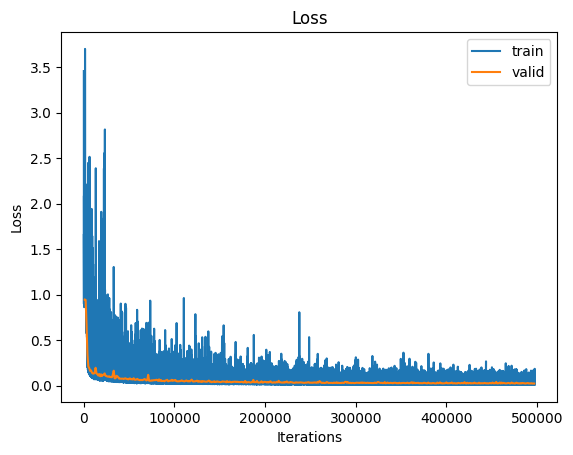

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

# visualize the loss curve
plt.figure()
plt.plot(*zip(*train_loss_list), label="train")
plt.plot(*zip(*eval_loss_list), label="valid")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

Load the checkpoint trained by us. Do **not** run this block if you have trained your model in the previous block.

In [18]:
################
## LOAD MODEL ##
################
simulator = LearnedSimulator()
simulator = simulator.cuda()
#!wget -O temp/models/WaterDrop_checkpoint.pt https://storage.googleapis.com/cs224w_course_project_dataset/Checkpoints/WaterDrop_checkpoint.pt
# checkpoint = torch.load("simulator_model_20epoch.pth")
# simulator.load_state_dict(checkpoint["model"])
model_save_path = "simulator_model_20epoch.pth"
simulator.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

## Visualization

Since the video is 1000 frames long, it might take a few minutes to rollout.

In [19]:
rollout_dataset = RolloutDataset(data_path, "valid")
simulator.eval()
rollout_data = rollout_dataset[0]
rollout_out = rollout(simulator, rollout_data, rollout_dataset.metadata, params["noise"])
rollout_out = rollout_out.permute(1, 0, 2)

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

TYPE_TO_COLOR = {
    3: "black",
    0: "green",
    7: "magenta",
    6: "gold",
    5: "blue",
}


def visualize_prepare(ax, particle_type, position, metadata):
    bounds = metadata["bounds"]
    ax.set_xlim(bounds[0][0], bounds[0][1])
    ax.set_ylim(bounds[1][0], bounds[1][1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(1.0)
    points = {type_: ax.plot([], [], "o", ms=2, color=color)[0] for type_, color in TYPE_TO_COLOR.items()}
    return ax, position, points


def visualize_pair(particle_type, position_pred, position_gt, metadata):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    plot_info = [
        visualize_prepare(axes[0], particle_type, position_gt, metadata),
        visualize_prepare(axes[1], particle_type, position_pred, metadata),
    ]
    axes[0].set_title("Ground truth")
    axes[1].set_title("Prediction")

    plt.close()

    def update(step_i):
        outputs = []
        for _, position, points in plot_info:
            for type_, line in points.items():
                mask = particle_type == type_
                line.set_data(position[step_i, mask, 0], position[step_i, mask, 1])
            outputs.append(line)
        return outputs

    return animation.FuncAnimation(fig, update, frames=np.arange(0, position_gt.size(0)), interval=10, blit=True)

anim = visualize_pair(rollout_data["particle_type"], rollout_out, rollout_data["position"], rollout_dataset.metadata)
HTML(anim.to_html5_video())

## Conclusion

Hope this Colab is helpful for you to understand how to apply GNN in a real-world application such as simulating complex physics! If you're interested in the technical details, please read our [medium post](https://) or look at the [original paper](https://arxiv.org/abs/2002.09405) by DeepMind. Thanks for spending your time with us!